# Imports

In [1]:
import pandas as pd
import sklearn.metrics as metrics
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, date, timedelta
import math
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import requests
import io
from time import sleep
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, TimeDistributed, LSTM, Lambda
from tensorflow.keras import regularizers
import tensorflow as tf
from IPython.display import display
import re
import talos

# Load data
load hospitalisations and trends for Belgium and France

In [2]:
# topics considered
list_topics = {
    #'Fièvre': '/m/0cjf0',
    #'Mal de gorge': '/m/0b76bty',
    #'Dyspnée': '/m/01cdt5',
    #'Agueusie': '/m/05sfr2',
    #'Anosmie': '/m/0m7pl',
    #'Coronavirus': '/m/01cpyy',
    #'Virus': '/m/0g9pc',
    #'Température corporelle humaine': '/g/1213j0cz',
    #'Épidémie': '/m/0hn9s',
    #'Symptôme': '/m/01b_06',
    #'Thermomètre': '/m/07mf1',
    #'Grippe espagnole': '/m/01c751',
    #'Paracétamol': '/m/0lbt3',
    #'Respiration': '/m/02gy9_',
    #'Toux': '/m/01b_21'
}

# hospitalisations features given as input
list_hosp_features = [
    #'NEW_HOSP',
    'TOT_HOSP',
    #'TOT_HOSP_log',
    #'TOT_HOSP_pct',
]

geocodes = {
    'BE': "Belgique",
    'FR-A': "Alsace-Champagne-Ardenne-Lorraine",
    'FR-B': "Aquitaine-Limousin-Poitou-Charentes",
    'FR-C': "Auvergne-Rhône-Alpes",
    'FR-J': 'Ile-de-France'
}

Additional information: what is the target, should some features remain unscaled?

In [3]:
# target, should be one of the hosp features
target = 'TOT_HOSP'

# features that should not be scaled
unscaled = [
    #'NEW_HOSP',
    #'TOT_HOSP',
    #'TOT_HOSP_log',
    #'TOT_HOSP_pct',
    #'Fièvre',
    #'Mal de gorge',
    #'Dyspnée',
    #'Agueusie',
    #'Anosmie',
    #'Coronavirus',
    #'Virus',
    #'Température corporelle humaine',
    #'Épidémie',
    #'Symptôme',
    #'Thermomètre',
    #'Grippe espagnole',
    #'Paracétamol',
    #'Respiration',
    #'Toux',
]

In [4]:
date_begin = "2020-02-01"

def log_values(df, columns: list = None, base: int = 10, inf_value='drop'):
    """
    add log values to the dataframe
    :param df: dataframe to change
    :param columns: list of name of the columns that needs to be modified. None= all columns
    :param base: base for the logarithm. Supported: [10]. If not in the list, use logarithm in base e
    :param inf_value: value to give for the inf created by the log. Can be integer or 'drop' (dropping the values)
    :return dataframe with log values for the corresponding columns
    """
    if columns==None:
        columns = df.columns
    new_columns = [f"{name}_log" for name in columns]
        
    if base==10:
        df[new_columns] = np.log10(df[columns])
    else:
        df[new_columns] = np.log(df[columns]) / np.log(base)
        
    if inf_value == 'drop':
        df = df.replace([np.inf, -np.inf], np.nan).dropna()
    else: #inf_value should be an integer
        df = df.replace([np.inf, -np.inf], inf_value)
    return df
        

def pct_values(df, columns: list = None, add_one: bool = False):
    """
    add percentage values to the dataframe
    :param df: dataframe to change
    :param columns: list of name of the columns that needs to be modified. None= all columns
    :param add_one: if True, the percentage of difference add a value of 100% to each percentage
    :return dataframe with pct change values for the corresponding columns
    """
    if columns==None:
        columns = df.columns
    new_columns = [f"{name}_pct" for name in columns]
    df[new_columns] = df[columns].pct_change()
    if add_one:
        df[new_columns] = df[new_columns] + 1
    return df
    

def create_dataframe_hospi(hospi_france_tot, hospi_france_new, hospi_belgium, department_france, geo, 
                           new_hosp_in=True, tot_hosp=True):
    """
    Creates the dataframe containing the number of daily new hospitalizations
    with respect to the date and the localisation (FR and BE)
    :param hospi_france_tot: url/path for the total french hospitalisations csv
    :param hospi_france_new: url/path for the new french hospitalisations csv
    :param hospi_belgium: url/path for the belgian hospitalisations csv
    :param department_france: url/path for the mapping of french department to regions
    :param geo: geocode of the region that should be incuded in the final dict
    :param new_hosp_in: if True, includes the new daily hospitalisations (inwards)
    :param tot_hosp: if True, includes the total hospitalisations
    :return dict of {geocode: hosp_df} where hosp is hospitalisation dataframe of each geocode
    """
    columns_be = {}  # only for belgium, not for france (the files are handled differently)
    data_columns = []  # final data columns that will be present in the df
    if new_hosp_in:
        columns_be['NEW_IN'] = 'sum'
        data_columns.append("NEW_HOSP")
    if tot_hosp:
        columns_be['TOTAL_IN'] = 'sum'
        data_columns.append("TOT_HOSP")
    if len(columns_be) == 0:
        raise Exception("no hospitalisation column specified")
    date_parser = lambda x: datetime.strptime(x, "%Y-%m-%d")
    departements = pd.read_csv(department_france)
    
    # French data: total hospitalisation
    if tot_hosp:
        hospitalisations = pd.read_csv(hospi_france_tot, sep=";", parse_dates=['jour'], date_parser=date_parser)
        hospitalisations = hospitalisations[hospitalisations['sexe'] == 0]  # sex=0: men and women
        data_fr_tot = hospitalisations.join(departements.set_index('departmentCode'), on="dep").groupby(
            ["regionTrends", "jour"], as_index=False).agg({"hosp": "sum"})
    
    # French data: new hospitalisation
    if new_hosp_in:
        hospitalisations = pd.read_csv(hospi_france_new, sep=";", parse_dates=['jour'], date_parser=date_parser)
        data_fr_new = hospitalisations.join(departements.set_index('departmentCode'), on="dep").groupby(
            ["regionTrends", "jour"],as_index=False).agg({"incid_hosp": "sum"})
    
    # merge the french data
    common_columns = ["regionTrends", "jour"]
    if tot_hosp and new_hosp_in:
        data_fr = data_fr_tot.merge(data_fr_new, how='outer',left_on=common_columns, right_on=common_columns).fillna(0)
    elif tot_hosp:
        data_fr = data_fr_tot
    elif new_hosp_in:
        data_fr = data_fr_new
    data_fr = data_fr.rename(columns={"jour": "DATE", "regionTrends": "LOC", "hosp": "TOT_HOSP", "incid_hosp": "NEW_HOSP"})
    
    # Belgian data
    data_be = pd.read_csv(hospi_belgium, parse_dates=['DATE'], date_parser=date_parser).groupby(
        ["DATE"], as_index=False).agg(columns_be).rename(
        columns={"TOTAL_IN": "TOT_HOSP", "NEW_IN": "NEW_HOSP"})
    data_be["LOC"] = "BE"
    
    # Full data
    full_data = data_fr.append(data_be).set_index(["LOC", "DATE"])
    
    # find smallest date for each loc and highest common date
    smallest = {}
    highest = {}
    for loc, date_current in full_data.index:
        if loc not in smallest or smallest[loc] > date_current:
            smallest[loc] = date_current
        if loc not in highest or highest[loc] < date_current:
            highest[loc] = date_current
        
    highest_date = min(highest.values())
    base_date = datetime.strptime(date_begin, "%Y-%m-%d").date()

    # Add "fake" data (zeroes before the beginning of the crisis) for each loc
    toadd = []
    add_entry = [0 for i in range(len(data_columns))]  # each missing entry consist of zero for each data col
    for loc, sm in smallest.items():
        end = sm.date()
        cur = base_date

        while cur != end:
            toadd.append([cur, loc, *add_entry])
            cur += timedelta(days=1)
            
    full_data = pd.DataFrame(toadd, columns=["DATE", "LOC", *data_columns]).append(full_data.reset_index()).set_index(
        ["LOC", "DATE"])
    data_dic = {}
    
    for k, v in geo.items():
        data_dic[k] = full_data.iloc[(full_data.index.get_level_values('LOC') == k) & 
                                     (full_data.index.get_level_values('DATE') <= highest_date)]
    return data_dic


def create_df_trends(url_trends, geo):
    """
    return dic of {geo: df} for the trends
    """
    date_parser = lambda x: datetime.strptime(x, "%Y-%m-%d")
    renaming = {v: k for k, v in list_topics.items()}  # change topic_mid to topic_title in the dataframe
    if len(renaming)==0:
        return {k: pd.DataFrame() for k in geocodes}
    result = {}
    for k, v in geo.items():
        all_trends = []
        for term in list_topics.keys():
            path = f"{url_trends}{k}-{term}.csv"
            encoded_path = requests.get(path).content
            df_trends = pd.read_csv(io.StringIO(encoded_path.decode("utf-8")),
                                    parse_dates=['date'], date_parser=date_parser
                                   ).rename(columns={"date": "DATE"})
            df_trends['LOC'] = k
            df_trends.rename(columns=renaming, inplace=True)
            df_trends.set_index(['LOC', 'DATE'], inplace=True)
            all_trends.append(df_trends)
        result[k] = pd.concat(all_trends, axis=1)
    return result

In [5]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

url_trends = "https://raw.githubusercontent.com/gerardmargaux/CovidThesis/master/data/trends/model/"
url_hospi_belgium = "https://raw.githubusercontent.com/gerardmargaux/CovidThesis/master/data/hospi/be-covid-hospi.csv"
url_department_france = "https://raw.githubusercontent.com/gerardmargaux/CovidThesis/master/src/france_departements.csv"
url_hospi_france_new = "https://raw.githubusercontent.com/gerardmargaux/CovidThesis/master/data/hospi/fr-covid-hospi.csv"
url_hospi_france_tot = "https://raw.githubusercontent.com/gerardmargaux/CovidThesis/master/data/hospi/fr-covid-hospi-total.csv"

# Percentage is True if we want to take the difference of variation between today and yesterday in percentage
# Total is True if we want to add the absolute total value to the input of the model
df_trends = create_df_trends(url_trends, geocodes)
df_hospi = create_dataframe_hospi(url_hospi_france_tot, url_hospi_france_new, url_hospi_belgium, 
                                  url_department_france, geocodes)
for k in geocodes.keys():
    # Rolling average of 7 days 
    df_hospi[k] = df_hospi[k].rolling(7, center=True).mean().dropna()
    df_trends[k] = df_trends[k].rolling(7, center=True).mean().dropna()
    df_hospi[k] = log_values(df_hospi[k], columns=['TOT_HOSP'])
    df_hospi[k] = pct_values(df_hospi[k], columns=['TOT_HOSP'])
    df_hospi[k] = df_hospi[k][list_hosp_features]
    
    """
    print(f"--------------------{k}-----------------------")
    plt.figure()
    plt.plot(df_hospi[k]['HOSP'].reset_index().drop(columns=["LOC"]).set_index('DATE'), label='Diff hospi')
    plt.legend()
    plt.show()
    plt.figure()
    plt.plot(df_hospi[k]['TOT_HOSP'].reset_index().drop(columns=["LOC"]).set_index('DATE'), label='Total hospi')
    plt.legend()
    plt.show()
    plt.figure()
    plt.plot(df_trends[k]['Fièvre'].reset_index().drop(columns=["LOC"]).set_index('DATE'), label='Fièvre')
    plt.plot(df_trends[k]['Mal de gorge'].reset_index().drop(columns=["LOC"]).set_index('DATE'), label='Mal de gorge')
    plt.plot(df_trends[k]['Agueusie'].reset_index().drop(columns=["LOC"]).set_index('DATE'), label='Agueusie')
    plt.legend()
    plt.show()
    """

# Preprocess data

## Normalization [0,1]

In [6]:
df_hospi['BE']

TOT_HOSP
LOC DATE                   
BE  2020-03-12    38.000000
    2020-03-13    90.857143
    2020-03-14   161.857143
    2020-03-15   254.714286
    2020-03-16   375.285714
...                     ...
    2021-01-16  1909.285714
    2021-01-17  1909.428571
    2021-01-18  1914.142857
    2021-01-19  1920.857143
    2021-01-20  1930.857143

[315 rows x 1 columns]

In [7]:
inverse_param = {}
scaler = MinMaxScaler(feature_range=(0, 1))
for k in geocodes.keys():
    if len(list_topics) !=0:
        to_scale = [name for name in df_trends[k].columns if name not in unscaled]
        df_trends[k] = pd.DataFrame(scaler.fit_transform(df_trends[k].values), columns=to_scale, index=df_trends[k].index)
    # store a tuple of min,max
    inverse_param[k] = (df_hospi[k][target].min(), df_hospi[k][target].max())
    to_scale = [name for name in df_hospi[k].columns if name not in unscaled]
    df_hospi[k][to_scale] = pd.DataFrame(scaler.fit_transform(df_hospi[k][to_scale].values), columns=to_scale, index=df_hospi[k].index)
# store the inverse transform for the target only
inverse_transform = lambda df,k: df[[target]] * (inverse_param[k][1] - inverse_param[k][0]) + inverse_param[k][0] 
inverse_transform_fun = lambda val,k: val * (inverse_param[k][1] - inverse_param[k][0]) + inverse_param[k][0]
df_hospi['BE']

TOT_HOSP
LOC DATE                
BE  2020-03-12  0.000000
    2020-03-13  0.007370
    2020-03-14  0.017270
    2020-03-15  0.030217
    2020-03-16  0.047029
...                  ...
    2021-01-16  0.260921
    2021-01-17  0.260941
    2021-01-18  0.261598
    2021-01-19  0.262534
    2021-01-20  0.263928

[315 rows x 1 columns]

In [8]:
inverse_transform(df_hospi['BE'], 'BE')

TOT_HOSP
LOC DATE                   
BE  2020-03-12    38.000000
    2020-03-13    90.857143
    2020-03-14   161.857143
    2020-03-15   254.714286
    2020-03-16   375.285714
...                     ...
    2021-01-16  1909.285714
    2021-01-17  1909.428571
    2021-01-18  1914.142857
    2021-01-19  1920.857143
    2021-01-20  1930.857143

[315 rows x 1 columns]

Map to the sum of hospitalizations

In [9]:
def mapper(data, loc):
    allowed_map = ['TOT_HOSP']  # implemented mapping
    if target == 'TOT_HOSP':
        return [inverse_transform_fun(val,loc) for val in data]
    else:
        raise Exception(f"cannot map {target} to TOT_HOSP")
    
    



## Days used for the forecast
Each forecast is done for `n_forecast` days and uses `n_samples` days before to construct the prediction

In [10]:
n_forecast = 15  # Number of days we want to predict
n_samples = 25  # Number of days used to make the prediction
shift_hospi = 1  # delay between a date and its newest hosp value for this date 
# (ex: 26/10's newest value is for 25/10)
shift_trends = 1  # delay between a date and its newest trends value for this date

## Add lag

In [11]:
def timeseries_shift(data, lag, dropna=True):
    """
    Changes all columns with their shifted data
    """
    return data.shift(lag).dropna()

for k in geocodes.keys():
    df_hospi[k] = timeseries_shift(df_hospi[k], shift_hospi)
    df_trends[k] = timeseries_shift(df_trends[k], shift_trends)

In [12]:
def timeseries_add_lag(data, lag, dropna=True):
    #Adds lagged values to dataframe
    df = pd.DataFrame(data)
    init_columns = df.columns
    columns = [df.shift(i) for i in range(lag-1, 0, -1)]
    renaming = {}  # rename the columns
    delay = lag-1
    for i in range(lag-1):
        for k in init_columns:
            renaming[k] = f'{k}(t-{delay})'
        columns[i].rename(columns=renaming ,inplace=True)
        delay -= 1
    columns.append(df)
    df = pd.concat(columns, axis=1)
    return df.dropna() if dropna else df


if len(list_topics) !=0:
    merged_df = {k: pd.merge(df_hospi[k], df_trends[k], left_index=True, right_index=True).dropna() for k,v in geocodes.items()}
else:
    merged_df = {k: df_hospi[k] for k in geocodes}
    
# use the same date interval in all dataframes
min_date = datetime.strptime("1990-12-01", "%Y-%m-%d").date()
max_date = datetime.strptime("2050-12-01", "%Y-%m-%d").date()
for k in merged_df:
    index_date = merged_df[k].index.get_level_values(1)
    min_date = max(min_date, index_date.min())
    max_date = min(max_date, index_date.max())
for k in merged_df:
    merged_df[k] = merged_df[k].loc[pd.IndexSlice[:,min_date:max_date,:]]    

n_features = len(merged_df['BE'].columns)
print(n_features)
lagged_df = {}
for k in geocodes.keys():
    lagged_df[k] = timeseries_add_lag(merged_df[k], n_samples)

1


In [13]:
merged_df['BE']

TOT_HOSP
LOC DATE                
BE  2020-03-16  0.030217
    2020-03-17  0.047029
    2020-03-18  0.068960
    2020-03-19  0.096528
    2020-03-20  0.124016
...                  ...
    2021-01-16  0.260921
    2021-01-17  0.260921
    2021-01-18  0.260941
    2021-01-19  0.261598
    2021-01-20  0.262534

[311 rows x 1 columns]

In [14]:
lagged_df['BE']

TOT_HOSP(t-24)  TOT_HOSP(t-23)  TOT_HOSP(t-22)  \
LOC DATE                                                         
BE  2020-04-09        0.030217        0.047029        0.068960   
    2020-04-10        0.047029        0.068960        0.096528   
    2020-04-11        0.068960        0.096528        0.124016   
    2020-04-12        0.096528        0.124016        0.154154   
    2020-04-13        0.124016        0.154154        0.186881   
...                        ...             ...             ...   
    2021-01-16        0.341852        0.337131        0.333566   
    2021-01-17        0.337131        0.333566        0.330179   
    2021-01-18        0.333566        0.330179        0.327391   
    2021-01-19        0.330179        0.327391        0.324642   
    2021-01-20        0.327391        0.324642        0.319463   

                TOT_HOSP(t-21)  TOT_HOSP(t-20)  TOT_HOSP(t-19)  \
LOC DATE                                                         
BE  2020-04-09        0.096528        0.124016        0.154154   
    2020-04-10        0.124016        0.154154        0.186881   
    2020-04-11        0.154154        0.186881        0.228134   
    2020-04-12        0.186881        0.228134        0.272613   
    2020-04-13        0.228134        0.272613        0.323387   
...                        ...             ...             ...   
    2021-01-16        0.330179        0.327391        0.324642   
    2021-01-17        0.327391        0.324642        0.319463   
    2021-01-18        0.324642        0.319463        0.315459   
    2021-01-19        0.319463        0.315459        0.312192   
    2021-01-20        0.315459        0.312192        0.308727   

                TOT_HOSP(t-18)  TOT_HOSP(t-17)  TOT_HOSP(t-16)  \
LOC DATE                                                         
BE  2020-04-09        0.186881        0.228134        0.272613   
    2020-04-10        0.228134        0.272613        0.323387   
    2020-04-11        0.272613        0.323387        0.377268   
    2020-04-12        0.323387        0.377268        0.433719   
    2020-04-13        0.377268        0.433719        0.493755   
...                        ...             ...             ...   
    2021-01-16        0.319463        0.315459        0.312192   
    2021-01-17        0.315459        0.312192        0.308727   
    2021-01-18        0.312192        0.308727        0.304464   
    2021-01-19        0.308727        0.304464        0.298747   
    2021-01-20        0.304464        0.298747        0.293628   

                TOT_HOSP(t-15)  ...  TOT_HOSP(t-9)  TOT_HOSP(t-8)  \
LOC DATE                        ...                                 
BE  2020-04-09        0.323387  ...       0.646216       0.683326   
    2020-04-10        0.377268  ...       0.683326       0.712049   
    2020-04-11        0.433719  ...       0.712049       0.734757   
    2020-04-12        0.493755  ...       0.734757       0.751927   
    2020-04-13        0.550505  ...       0.751927       0.766388   
...                        ...  ...            ...            ...   
    2021-01-16        0.308727  ...       0.284684       0.280103   
    2021-01-17        0.304464  ...       0.280103       0.275999   
    2021-01-18        0.298747  ...       0.275999       0.272613   
    2021-01-19        0.293628  ...       0.272613       0.269844   
    2021-01-20        0.290262  ...       0.269844       0.267653   

                TOT_HOSP(t-7)  TOT_HOSP(t-6)  TOT_HOSP(t-5)  TOT_HOSP(t-4)  \
LOC DATE                                                                     
BE  2020-04-09       0.712049       0.734757       0.751927       0.766388   
    2020-04-10       0.734757       0.751927       0.766388       0.774276   
    2020-04-11       0.751927       0.766388       0.774276       0.779316   
    2020-04-12       0.766388       0.774276       0.779316       0.782304   
    2020-04-13       0.774276       0.779316       0.782304       0.78043

## Reshape
The data is reshaped in order to obtain the right format for LSTM:

`[nb_samples, timesteps, input_dim]`

In [15]:
# shape format for LSTM: [nb_samples, timesteps, input_dim]
dataset = {}
for k in geocodes.keys():
    dataset[k] = lagged_df[k].values.reshape(lagged_df[k].shape[0], n_samples, n_features)
dataset['BE'].shape

(287, 25, 1)

We want the targets to be always differents. For instance, if we use 2 days of forecast based on 3 days of data and the days are indexed as integers we want to have:
1. `x: [1,2,3]`, `y: [4,5]`
2. `x: [3,4,5]`, `y: [6,7]`
2. `x: [5,6,7]`, `y: [8,9]`

and so on. **But** this is only done for the fitting of the data. For the prediction itself, we will do it with one days of steps. In the end, if we use days 1 to 7 for the fit and want to predict afterwards, it will look like:

- **fit**: 
    1. `x: [1,2,3]`, `y: [4,5]`
    2. `x: [3,4,5]`, `y: [6,7]`
- **prediction**
    1. `x: [5,6,7]`, `y: [8,9]`
    2. `x: [6,7,8]`, `y: [9,10]`
    
    and so on
    
The prediction presents overlaps in order to obtain a real-time tool, that can be actualized every day

In [16]:
target_idx = lagged_df['BE'].columns.to_list().index(target)
target_idx = target_idx % ((n_samples-1) * n_features)
target_idx

0

In [17]:
# we take all possible dates for y. If not all dates can be taken, the first dates are dropped
first_set = (len(dataset) - 1) % n_forecast
all_x_set = {}
all_y_set = {}
for k in geocodes:
    all_y_set[k] = np.array([ [dataset[k][i+j+1,n_samples-1,target_idx] for j in range(n_forecast)] for i in range(first_set, len(dataset[k])-n_forecast)])
    all_x_set[k] = np.array([ dataset[k][i] for i in range(first_set, len(dataset[k])-n_forecast)])
    all_y_set[k] = all_y_set[k].reshape(len(all_x_set[k]), n_forecast, 1)

In [18]:
dates = [d.to_pydatetime().date() for d in lagged_df['BE'].index.get_level_values(1)]
x_dates = [ dates[i] for i in range(first_set, len(dataset['BE'])-n_forecast)]
y_dates = [ [dates[i+j+1] for j in range(n_forecast)] for i in range(first_set, len(dataset['BE'])-n_forecast)]
print(f'y_dates=\n', y_dates)
print(f'x_dates=\n', x_dates)

y_dates=
 [[datetime.date(2020, 4, 14), datetime.date(2020, 4, 15), datetime.date(2020, 4, 16), datetime.date(2020, 4, 17), datetime.date(2020, 4, 18), datetime.date(2020, 4, 19), datetime.date(2020, 4, 20), datetime.date(2020, 4, 21), datetime.date(2020, 4, 22), datetime.date(2020, 4, 23), datetime.date(2020, 4, 24), datetime.date(2020, 4, 25), datetime.date(2020, 4, 26), datetime.date(2020, 4, 27), datetime.date(2020, 4, 28)], [datetime.date(2020, 4, 15), datetime.date(2020, 4, 16), datetime.date(2020, 4, 17), datetime.date(2020, 4, 18), datetime.date(2020, 4, 19), datetime.date(2020, 4, 20), datetime.date(2020, 4, 21), datetime.date(2020, 4, 22), datetime.date(2020, 4, 23), datetime.date(2020, 4, 24), datetime.date(2020, 4, 25), datetime.date(2020, 4, 26), datetime.date(2020, 4, 27), datetime.date(2020, 4, 28), datetime.date(2020, 4, 29)], [datetime.date(2020, 4, 16), datetime.date(2020, 4, 17), datetime.date(2020, 4, 18), datetime.date(2020, 4, 19), datetime.date(2020, 4, 20), date

## Split into train - test set

In [19]:
datapoints = {loc: (all_x_set[loc], all_y_set[loc]) for loc in geocodes}
print(datapoints['BE'][0].shape)
print(datapoints['BE'][1].shape)
# shape format for LSTM: [nb_samples, timesteps, input_dim]

(268, 25, 1)
(268, 15, 1)


In [20]:
model = Sequential()
model.add(LSTM(32, input_shape=(n_samples, n_features), return_sequences=True))
model.add(LSTM(64, input_shape=(n_samples, n_features), return_sequences=False))
model.add(Dense(n_forecast))
model.compile(loss="mse", optimizer='adam')
print(model.output_shape)

(None, 15)


## Real-time prediction

In [21]:
fit_first_days = 280  # use 'fit_first_days' days for the first fit
fit_steps_days = 30  # every 'fit_steps_days' days, do a new fit of the data
epochs = 2800 # epochs used to train the model

In [22]:
def get_x_dates(idx):
    return np.array(x_dates)[idx]
    
def get_y_dates(idx, horizon=1):
    """
    return the target dates on the corresponding indexes
    :param horizon: int corresponding to the horizon of dates. Can be
        - a value in [1, n_forecast] corresponding to the given horizon date (1: tomorrow, 2: in two days, ...)
        - None gives all target dates in [1, n_forecast]
    """
    result_dates = np.array(y_dates)[idx]
    if horizon is not None:
        result_dates = result_dates[:,horizon-1]
    return result_dates

def data_generator(idx):
    """
    yield data points (X,Y) in all possible loc, on the indices provided
    """
    while True:
        for loc in datapoints:
            yield (datapoints[loc][0][idx],
                  datapoints[loc][1][idx])
            
def data_value_region(idx, loc):
    return (datapoints[loc][0][idx], datapoints[loc][1][idx])

In [56]:
def plot_prediction_vs_actual(predicted, idx, loc, horizon=1, show_fit=50, mode=0, map_to_hosp=True):
    """
    
    :param loc: location of the prediction
    :param predicted: value predicted
    :param idx: index of the y_values used
    :param horizon: horizon that must be plot
    :param show_fit: max number of days of fit that must be plot
    :param mode: used when horizon > 1. tell how to plot with respect to the horizons
        - mode = 0: plot one graph for all values for this specific horizon
        - mode = 1: plot one graph for all horizon in [1, horizon]
    :param map_to_hosp: if True, show the plot of predictions mapped to the total number of hosp
    """
    target_expected = data_value_region(idx, loc)[1]
    
    if mode == 0:
        horizon_range = range(horizon, horizon+1)
    elif mode == 1:
        horizon_range = range(1, horizon+1)
        
    for horizon in horizon_range:
        fig = plt.figure(figsize=(6,3))
        if show_fit > 0:
            fit_idx = [idx[0]-i for i in range(show_fit, 0, -1) if idx[0]-i >= 0]
            fit_dates = get_y_dates(fit_idx, horizon=horizon)
            # get all predictions of corresponding horizon that were used to fit the model
            fit_values = data_value_region(fit_idx, loc)[1][:,horizon-1].reshape(-1)
            if map_to_hosp:
                fit_values = mapper(fit_values, loc)
            plt.plot(fit_dates, fit_values, label="fitting used")

        prediction_dates = get_y_dates(idx, horizon=horizon)
        if map_to_hosp:
            target_expected_map = mapper(target_expected[:,horizon-1].reshape(-1), loc)
        else:
            target_expected_map = target_expected[:,horizon-1].reshape(-1)
        plt.plot(prediction_dates, target_expected_map, marker=".", label="True value")

        if map_to_hosp:
            prediction = mapper(predicted[:,horizon-1].reshape(-1), loc)
        else:
            prediction = predicted[:,horizon-1].reshape(-1)
        plt.plot(prediction_dates, prediction, marker='.', label=f"prediction horizon {horizon}")

        ax = fig.axes[0]
        # set locator
        if len(idx) + show_fit > 50:  # monthly locator
            ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
        else:  # weekly locator
            ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
        # set formatter
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
        # set font and rotation for date tick labels
        plt.gcf().autofmt_xdate()
        plt.legend()
        plt.grid()
        if mode != 0:
            plt.show()
    

In [25]:
all_prediction = {k: [] for k in geocodes}
all_targets = {k: [] for k in geocodes}
fit_used = []
fit_dates_used = []
prediction_idx = []
prediction_dates_used = []
for day_fit in range(fit_first_days, len(all_x_set['BE']), fit_steps_days):
    fit_idx = list(range(0,day_fit,n_forecast))
    fit_used.append(fit_idx)
    
    history = model.fit(data_generator(fit_idx), steps_per_epoch=len(geocodes), 
                        epochs=epochs, verbose=1, shuffle=True)
    
    max_predict = min(day_fit + fit_steps_days, len(all_x_set['BE']))
    predict_idx = list(range(day_fit, max_predict))
    
    fit_dates_used.append(np.array(y_dates[:max(fit_idx)+1]))
    predict_dates = np.array([y_dates[i] for i in predict_idx])
    prediction_idx.append(predict_idx)
    prediction_dates_used.append(predict_dates)
    
    for loc in geocodes:
        X,Y = data_value_region(predict_idx, loc)
        prediction = model.predict(X)
        all_prediction[loc].append(prediction)
        all_targets[loc].append(Y)

In [26]:
for loc in all_prediction:
    for i, pred in enumerate(all_prediction[loc]):
        prediction = pred
        fit = datapoints[loc][1][:max(fit_used[i])+1][:,0].reshape(-1)
        target_expected = np.array(all_targets[loc][i])
        
        fit_dates = fit_dates_used[i][:,0]
        prediction_dates = prediction_dates_used[i][:,0]
        plot_prediction_vs_actual(prediction, prediction_idx[i], loc)
        plt.title(loc)

# Comparison between several models

In [23]:
prop_train = 0.6 # 60% of data for training
prop_valid = 0.2 # 20% of data for validation
prop_test = 0.2 # 20% of data for testing

date_f = "%Y-%m-%d"
lagged_df_no_index = lagged_df['BE'].reset_index()
first_date = datetime.strptime(lagged_df_no_index['DATE'].min().strftime(date_f), date_f).date()
last_date = datetime.strptime(lagged_df_no_index['DATE'].max().strftime(date_f), date_f).date()
total_days = (last_date - first_date).days

end_train = first_date + timedelta(days=total_days*prop_train)
end_valid = end_train + timedelta(days=total_days*prop_valid)
end_test = end_valid + timedelta(days=total_days*prop_test)

end_train = end_train.strftime(date_f)
end_valid = end_valid.strftime(date_f)
end_test = end_test.strftime(date_f)

print(f"Training period : {first_date.strftime(date_f)} -> {end_train}")
print(f"Validation period : {end_train} -> {end_valid}")
print(f"Testing period : {end_valid} -> {end_test}")

Training period : 2020-04-09 -> 2020-09-27
Validation period : 2020-09-27 -> 2020-11-23
Testing period : 2020-11-23 -> 2021-01-19


In [24]:
max_dates = [datetime.strptime(end_train, date_f).date(),
            datetime.strptime(end_valid, date_f).date(),
            datetime.strptime(end_test, date_f).date()]
max_dates[-1] = min(max(x_dates), max_dates[-1])
max_train_idx, max_valid_idx, max_test_idx = np.where(np.isin(x_dates, max_dates))[0]

train_idx = list(reversed(range(max_train_idx, -1, -n_forecast)))
valid_idx = list(range(max_train_idx+1, max_valid_idx+1))
test_idx = list(range(max_valid_idx+1, max_test_idx+1))

def train_generator():
    return data_generator(train_idx)

def validation_generator():
    return data_generator(valid_idx)

def test_generator():
    return data_generator(test_idx)

train_datapoints = {loc: data_value_region(train_idx, loc) for loc in geocodes}
valid_datapoints = {loc: data_value_region(valid_idx, loc) for loc in geocodes}
test_datapoints = {loc: data_value_region(test_idx, loc) for loc in geocodes}

## Toy model

In [26]:
model = Sequential()
model.add(LSTM(32, input_shape=(n_samples, n_features), return_sequences=True))
model.add(LSTM(32, input_shape=(n_samples, n_features), return_sequences=False))
model.add(Dense(n_forecast))
LSTMModel = model
print(model.output_shape)

(None, 15)


In [27]:
#history = model.fit(x_train, y_train, epochs=400, verbose=1, shuffle=False)
LSTMModel.compile(loss="mse", optimizer='adam')
history = LSTMModel.fit(train_generator(), steps_per_epoch=len(train_datapoints), epochs=epochs, verbose=1, shuffle=False, 
          validation_data=validation_generator(),
          validation_steps=len(valid_datapoints))

Epoch 1/2800
5/5 [==============================] - 1s 164ms/step - loss: 0.0846 - val_loss: 0.3039
Epoch 2/2800
5/5 [==============================] - 0s 26ms/step - loss: 0.0689 - val_loss: 0.2641
Epoch 3/2800
5/5 [==============================] - 0s 26ms/step - loss: 0.0529 - val_loss: 0.2154
Epoch 4/2800
5/5 [==============================] - 0s 26ms/step - loss: 0.0356 - val_loss: 0.1563
Epoch 5/2800
5/5 [==============================] - 0s 26ms/step - loss: 0.0222 - val_loss: 0.1081
Epoch 6/2800
5/5 [==============================] - 0s 26ms/step - loss: 0.0159 - val_loss: 0.0999
Epoch 7/2800
5/5 [==============================] - 0s 26ms/step - loss: 0.0122 - val_loss: 0.1020
Epoch 8/2800
5/5 [==============================] - 0s 26ms/step - loss: 0.0083 - val_loss: 0.0994
Epoch 9/2800
5/5 [==============================] - 0s 26ms/step - loss: 0.0068 - val_loss: 0.1057
Epoch 10/2800
5/5 [==============================] - 0s 26ms/step - loss: 0.0057 - val_loss: 0.1046
Epoch 11

5/5 [==============================] - 0s 26ms/step - loss: 0.0011 - val_loss: 0.0520
Epoch 84/2800
5/5 [==============================] - 0s 27ms/step - loss: 0.0011 - val_loss: 0.0518
Epoch 85/2800
5/5 [==============================] - 0s 51ms/step - loss: 0.0011 - val_loss: 0.0516
Epoch 86/2800
5/5 [==============================] - 0s 25ms/step - loss: 0.0011 - val_loss: 0.0514
Epoch 87/2800
5/5 [==============================] - 0s 25ms/step - loss: 0.0011 - val_loss: 0.0512
Epoch 88/2800
5/5 [==============================] - 0s 27ms/step - loss: 0.0011 - val_loss: 0.0510
Epoch 89/2800
5/5 [==============================] - 0s 28ms/step - loss: 0.0010 - val_loss: 0.0508
Epoch 90/2800
5/5 [==============================] - 0s 28ms/step - loss: 0.0010 - val_loss: 0.0507
Epoch 91/2800
5/5 [==============================] - 0s 28ms/step - loss: 0.0010 - val_loss: 0.0505
Epoch 92/2800
5/5 [==============================] - 0s 28ms/step - loss: 0.0010 - val_loss: 0.0503
Epoch 93/2800


Epoch 162/2800
5/5 [==============================] - 0s 28ms/step - loss: 6.9241e-04 - val_loss: 0.0377
Epoch 163/2800
5/5 [==============================] - 0s 28ms/step - loss: 6.8933e-04 - val_loss: 0.0375
Epoch 164/2800
5/5 [==============================] - 0s 27ms/step - loss: 6.8412e-04 - val_loss: 0.0373
Epoch 165/2800
5/5 [==============================] - 0s 25ms/step - loss: 6.8159e-04 - val_loss: 0.0371
Epoch 166/2800
5/5 [==============================] - 0s 25ms/step - loss: 6.7595e-04 - val_loss: 0.0370
Epoch 167/2800
5/5 [==============================] - 0s 25ms/step - loss: 6.7417e-04 - val_loss: 0.0368
Epoch 168/2800
5/5 [==============================] - 0s 25ms/step - loss: 6.6790e-04 - val_loss: 0.0366
Epoch 169/2800
5/5 [==============================] - 0s 25ms/step - loss: 6.6709e-04 - val_loss: 0.0365
Epoch 170/2800
5/5 [==============================] - 0s 25ms/step - loss: 6.5996e-04 - val_loss: 0.0363
Epoch 171/2800
5/5 [==============================] - 0

5/5 [==============================] - 0s 25ms/step - loss: 5.2717e-04 - val_loss: 0.0288
Epoch 241/2800
5/5 [==============================] - 0s 26ms/step - loss: 5.2620e-04 - val_loss: 0.0287
Epoch 242/2800
5/5 [==============================] - 0s 26ms/step - loss: 5.2523e-04 - val_loss: 0.0287
Epoch 243/2800
5/5 [==============================] - 0s 25ms/step - loss: 5.2428e-04 - val_loss: 0.0286
Epoch 244/2800
5/5 [==============================] - 0s 25ms/step - loss: 5.2333e-04 - val_loss: 0.0286
Epoch 245/2800
5/5 [==============================] - 0s 25ms/step - loss: 5.2239e-04 - val_loss: 0.0285
Epoch 246/2800
5/5 [==============================] - 0s 25ms/step - loss: 5.2145e-04 - val_loss: 0.0285
Epoch 247/2800
5/5 [==============================] - 0s 25ms/step - loss: 5.2052e-04 - val_loss: 0.0284
Epoch 248/2800
5/5 [==============================] - 0s 25ms/step - loss: 5.1960e-04 - val_loss: 0.0284
Epoch 249/2800
5/5 [==============================] - 0s 26ms/step - l

5/5 [==============================] - 0s 25ms/step - loss: 4.6537e-04 - val_loss: 0.0256
Epoch 319/2800
5/5 [==============================] - 0s 25ms/step - loss: 4.6429e-04 - val_loss: 0.0256
Epoch 320/2800
5/5 [==============================] - 0s 25ms/step - loss: 4.6414e-04 - val_loss: 0.0256
Epoch 321/2800
5/5 [==============================] - 0s 26ms/step - loss: 4.6291e-04 - val_loss: 0.0255
Epoch 322/2800
5/5 [==============================] - 0s 25ms/step - loss: 4.6299e-04 - val_loss: 0.0255
Epoch 323/2800
5/5 [==============================] - 0s 25ms/step - loss: 4.6157e-04 - val_loss: 0.0255
Epoch 324/2800
5/5 [==============================] - 0s 25ms/step - loss: 4.6195e-04 - val_loss: 0.0254
Epoch 325/2800
5/5 [==============================] - 0s 25ms/step - loss: 4.6028e-04 - val_loss: 0.0254
Epoch 326/2800
5/5 [==============================] - 0s 25ms/step - loss: 4.6111e-04 - val_loss: 0.0254
Epoch 327/2800
5/5 [==============================] - 0s 25ms/step - l

5/5 [==============================] - 0s 31ms/step - loss: 4.2944e-04 - val_loss: 0.0235
Epoch 397/2800
5/5 [==============================] - 0s 32ms/step - loss: 4.2831e-04 - val_loss: 0.0236
Epoch 398/2800
5/5 [==============================] - 0s 30ms/step - loss: 4.3628e-04 - val_loss: 0.0235
Epoch 399/2800
5/5 [==============================] - 0s 27ms/step - loss: 4.4749e-04 - val_loss: 0.0234
Epoch 400/2800
5/5 [==============================] - 0s 26ms/step - loss: 4.4131e-04 - val_loss: 0.0233
Epoch 401/2800
5/5 [==============================] - 0s 25ms/step - loss: 4.2432e-04 - val_loss: 0.0233
Epoch 402/2800
5/5 [==============================] - 0s 25ms/step - loss: 4.2055e-04 - val_loss: 0.0233
Epoch 403/2800
5/5 [==============================] - 0s 26ms/step - loss: 4.2392e-04 - val_loss: 0.0233
Epoch 404/2800
5/5 [==============================] - 0s 26ms/step - loss: 4.2362e-04 - val_loss: 0.0234
Epoch 405/2800
5/5 [==============================] - 0s 26ms/step - l

5/5 [==============================] - 0s 26ms/step - loss: 4.2230e-04 - val_loss: 0.0221
Epoch 475/2800
5/5 [==============================] - 0s 26ms/step - loss: 3.9981e-04 - val_loss: 0.0221
Epoch 476/2800
5/5 [==============================] - 0s 26ms/step - loss: 3.9780e-04 - val_loss: 0.0221
Epoch 477/2800
5/5 [==============================] - 0s 27ms/step - loss: 3.9992e-04 - val_loss: 0.0222
Epoch 478/2800
5/5 [==============================] - 0s 29ms/step - loss: 4.0118e-04 - val_loss: 0.0223
Epoch 479/2800
5/5 [==============================] - 0s 27ms/step - loss: 4.1436e-04 - val_loss: 0.0222
Epoch 480/2800
5/5 [==============================] - 0s 27ms/step - loss: 4.3032e-04 - val_loss: 0.0221
Epoch 481/2800
5/5 [==============================] - 0s 26ms/step - loss: 4.1926e-04 - val_loss: 0.0221
Epoch 482/2800
5/5 [==============================] - 0s 26ms/step - loss: 3.9785e-04 - val_loss: 0.0221
Epoch 483/2800
5/5 [==============================] - 0s 26ms/step - l

5/5 [==============================] - 0s 26ms/step - loss: 3.7945e-04 - val_loss: 0.0213
Epoch 553/2800
5/5 [==============================] - 0s 25ms/step - loss: 3.8220e-04 - val_loss: 0.0214
Epoch 554/2800
5/5 [==============================] - 0s 25ms/step - loss: 3.9463e-04 - val_loss: 0.0214
Epoch 555/2800
5/5 [==============================] - 0s 27ms/step - loss: 4.1313e-04 - val_loss: 0.0213
Epoch 556/2800
5/5 [==============================] - 0s 28ms/step - loss: 4.0137e-04 - val_loss: 0.0212
Epoch 557/2800
5/5 [==============================] - 0s 28ms/step - loss: 3.8208e-04 - val_loss: 0.0212
Epoch 558/2800
5/5 [==============================] - 0s 31ms/step - loss: 3.7828e-04 - val_loss: 0.0212
Epoch 559/2800
5/5 [==============================] - 0s 27ms/step - loss: 3.8238e-04 - val_loss: 0.0213
Epoch 560/2800
5/5 [==============================] - 0s 26ms/step - loss: 3.8501e-04 - val_loss: 0.0213
Epoch 561/2800
5/5 [==============================] - 0s 26ms/step - l

5/5 [==============================] - 0s 28ms/step - loss: 3.6566e-04 - val_loss: 0.0207
Epoch 631/2800
5/5 [==============================] - 0s 25ms/step - loss: 3.6679e-04 - val_loss: 0.0207
Epoch 632/2800
5/5 [==============================] - 0s 25ms/step - loss: 3.6557e-04 - val_loss: 0.0208
Epoch 633/2800
5/5 [==============================] - 0s 25ms/step - loss: 3.7180e-04 - val_loss: 0.0209
Epoch 634/2800
5/5 [==============================] - 0s 25ms/step - loss: 3.9485e-04 - val_loss: 0.0208
Epoch 635/2800
5/5 [==============================] - 0s 25ms/step - loss: 3.9066e-04 - val_loss: 0.0207
Epoch 636/2800
5/5 [==============================] - 0s 25ms/step - loss: 3.6474e-04 - val_loss: 0.0207
Epoch 637/2800
5/5 [==============================] - 0s 25ms/step - loss: 3.6203e-04 - val_loss: 0.0206
Epoch 638/2800
5/5 [==============================] - 0s 26ms/step - loss: 3.6220e-04 - val_loss: 0.0207
Epoch 639/2800
5/5 [==============================] - 0s 25ms/step - l

5/5 [==============================] - 0s 26ms/step - loss: 3.7839e-04 - val_loss: 0.0203
Epoch 709/2800
5/5 [==============================] - 0s 25ms/step - loss: 3.6825e-04 - val_loss: 0.0202
Epoch 710/2800
5/5 [==============================] - 0s 25ms/step - loss: 3.5420e-04 - val_loss: 0.0202
Epoch 711/2800
5/5 [==============================] - 0s 26ms/step - loss: 3.5198e-04 - val_loss: 0.0202
Epoch 712/2800
5/5 [==============================] - 0s 80ms/step - loss: 3.5574e-04 - val_loss: 0.0203
Epoch 713/2800
5/5 [==============================] - 0s 25ms/step - loss: 3.6493e-04 - val_loss: 0.0203
Epoch 714/2800
5/5 [==============================] - 0s 26ms/step - loss: 3.8396e-04 - val_loss: 0.0203
Epoch 715/2800
5/5 [==============================] - 0s 25ms/step - loss: 3.7591e-04 - val_loss: 0.0202
Epoch 716/2800
5/5 [==============================] - 0s 25ms/step - loss: 3.6373e-04 - val_loss: 0.0202
Epoch 717/2800
5/5 [==============================] - 0s 25ms/step - l

5/5 [==============================] - 0s 26ms/step - loss: 3.5578e-04 - val_loss: 0.0204
Epoch 787/2800
5/5 [==============================] - 0s 25ms/step - loss: 3.6663e-04 - val_loss: 0.0202
Epoch 788/2800
5/5 [==============================] - 0s 26ms/step - loss: 3.5134e-04 - val_loss: 0.0202
Epoch 789/2800
5/5 [==============================] - 0s 25ms/step - loss: 3.3818e-04 - val_loss: 0.0202
Epoch 790/2800
5/5 [==============================] - 0s 25ms/step - loss: 3.4010e-04 - val_loss: 0.0203
Epoch 791/2800
5/5 [==============================] - 0s 25ms/step - loss: 3.3693e-04 - val_loss: 0.0204
Epoch 792/2800
5/5 [==============================] - 0s 25ms/step - loss: 3.5670e-04 - val_loss: 0.0204
Epoch 793/2800
5/5 [==============================] - 0s 25ms/step - loss: 3.5919e-04 - val_loss: 0.0202
Epoch 794/2800
5/5 [==============================] - 0s 25ms/step - loss: 3.4267e-04 - val_loss: 0.0203
Epoch 795/2800
5/5 [==============================] - 0s 25ms/step - l

5/5 [==============================] - 0s 25ms/step - loss: 3.1143e-04 - val_loss: 0.0206
Epoch 865/2800
5/5 [==============================] - 0s 25ms/step - loss: 3.0633e-04 - val_loss: 0.0206
Epoch 866/2800
5/5 [==============================] - 0s 25ms/step - loss: 3.1724e-04 - val_loss: 0.0207
Epoch 867/2800
5/5 [==============================] - 0s 25ms/step - loss: 3.3052e-04 - val_loss: 0.0206
Epoch 868/2800
5/5 [==============================] - 0s 25ms/step - loss: 3.2801e-04 - val_loss: 0.0206
Epoch 869/2800
5/5 [==============================] - 0s 28ms/step - loss: 3.0739e-04 - val_loss: 0.0205
Epoch 870/2800
5/5 [==============================] - 0s 25ms/step - loss: 3.0782e-04 - val_loss: 0.0207
Epoch 871/2800
5/5 [==============================] - 0s 25ms/step - loss: 3.0419e-04 - val_loss: 0.0207
Epoch 872/2800
5/5 [==============================] - 0s 26ms/step - loss: 3.2196e-04 - val_loss: 0.0207
Epoch 873/2800
5/5 [==============================] - 0s 25ms/step - l

5/5 [==============================] - 0s 25ms/step - loss: 2.8702e-04 - val_loss: 0.0207
Epoch 943/2800
5/5 [==============================] - 0s 25ms/step - loss: 2.8545e-04 - val_loss: 0.0209
Epoch 944/2800
5/5 [==============================] - 0s 25ms/step - loss: 2.7516e-04 - val_loss: 0.0208
Epoch 945/2800
5/5 [==============================] - 0s 25ms/step - loss: 2.8172e-04 - val_loss: 0.0209
Epoch 946/2800
5/5 [==============================] - 0s 25ms/step - loss: 2.8078e-04 - val_loss: 0.0207
Epoch 947/2800
5/5 [==============================] - 0s 25ms/step - loss: 2.8858e-04 - val_loss: 0.0208
Epoch 948/2800
5/5 [==============================] - 0s 25ms/step - loss: 2.8092e-04 - val_loss: 0.0207
Epoch 949/2800
5/5 [==============================] - 0s 25ms/step - loss: 2.7934e-04 - val_loss: 0.0208
Epoch 950/2800
5/5 [==============================] - 0s 25ms/step - loss: 2.7309e-04 - val_loss: 0.0208
Epoch 951/2800
5/5 [==============================] - 0s 25ms/step - l

Epoch 1020/2800
5/5 [==============================] - 0s 25ms/step - loss: 2.4381e-04 - val_loss: 0.0204
Epoch 1021/2800
5/5 [==============================] - 0s 25ms/step - loss: 2.4341e-04 - val_loss: 0.0203
Epoch 1022/2800
5/5 [==============================] - 0s 25ms/step - loss: 2.4941e-04 - val_loss: 0.0203
Epoch 1023/2800
5/5 [==============================] - 0s 25ms/step - loss: 2.4855e-04 - val_loss: 0.0203
Epoch 1024/2800
5/5 [==============================] - 0s 25ms/step - loss: 2.4798e-04 - val_loss: 0.0203
Epoch 1025/2800
5/5 [==============================] - 0s 93ms/step - loss: 2.4031e-04 - val_loss: 0.0203
Epoch 1026/2800
5/5 [==============================] - 0s 26ms/step - loss: 2.3883e-04 - val_loss: 0.0204
Epoch 1027/2800
5/5 [==============================] - 0s 26ms/step - loss: 2.3555e-04 - val_loss: 0.0204
Epoch 1028/2800
5/5 [==============================] - 0s 25ms/step - loss: 2.3723e-04 - val_loss: 0.0204
Epoch 1029/2800
5/5 [=========================

5/5 [==============================] - 0s 25ms/step - loss: 2.1909e-04 - val_loss: 0.0195
Epoch 1098/2800
5/5 [==============================] - 0s 25ms/step - loss: 2.1805e-04 - val_loss: 0.0194
Epoch 1099/2800
5/5 [==============================] - 0s 25ms/step - loss: 2.3163e-04 - val_loss: 0.0193
Epoch 1100/2800
5/5 [==============================] - 0s 25ms/step - loss: 2.2584e-04 - val_loss: 0.0192
Epoch 1101/2800
5/5 [==============================] - 0s 25ms/step - loss: 2.4406e-04 - val_loss: 0.0192
Epoch 1102/2800
5/5 [==============================] - 0s 25ms/step - loss: 2.2740e-04 - val_loss: 0.0195
Epoch 1103/2800
5/5 [==============================] - 0s 25ms/step - loss: 2.1839e-04 - val_loss: 0.0194
Epoch 1104/2800
5/5 [==============================] - 0s 27ms/step - loss: 2.1866e-04 - val_loss: 0.0199
Epoch 1105/2800
5/5 [==============================] - 0s 25ms/step - loss: 2.1374e-04 - val_loss: 0.0199
Epoch 1106/2800
5/5 [==============================] - 0s 25ms

5/5 [==============================] - 0s 25ms/step - loss: 2.3874e-04 - val_loss: 0.0173
Epoch 1175/2800
5/5 [==============================] - 0s 25ms/step - loss: 2.9090e-04 - val_loss: 0.0197
Epoch 1176/2800
5/5 [==============================] - 0s 26ms/step - loss: 2.5550e-04 - val_loss: 0.0175
Epoch 1177/2800
5/5 [==============================] - 0s 25ms/step - loss: 2.4960e-04 - val_loss: 0.0192
Epoch 1178/2800
5/5 [==============================] - 0s 25ms/step - loss: 2.3026e-04 - val_loss: 0.0177
Epoch 1179/2800
5/5 [==============================] - 0s 25ms/step - loss: 2.4197e-04 - val_loss: 0.0192
Epoch 1180/2800
5/5 [==============================] - 0s 25ms/step - loss: 2.2224e-04 - val_loss: 0.0176
Epoch 1181/2800
5/5 [==============================] - 0s 25ms/step - loss: 2.3956e-04 - val_loss: 0.0189
Epoch 1182/2800
5/5 [==============================] - 0s 25ms/step - loss: 2.2467e-04 - val_loss: 0.0174
Epoch 1183/2800
5/5 [==============================] - 0s 25ms

5/5 [==============================] - 0s 29ms/step - loss: 2.1809e-04 - val_loss: 0.0166
Epoch 1252/2800
5/5 [==============================] - 0s 27ms/step - loss: 2.9179e-04 - val_loss: 0.0188
Epoch 1253/2800
5/5 [==============================] - 0s 31ms/step - loss: 2.6361e-04 - val_loss: 0.0167
Epoch 1254/2800
5/5 [==============================] - 0s 29ms/step - loss: 2.9808e-04 - val_loss: 0.0183
Epoch 1255/2800
5/5 [==============================] - 0s 28ms/step - loss: 2.5628e-04 - val_loss: 0.0177
Epoch 1256/2800
5/5 [==============================] - 0s 27ms/step - loss: 2.2925e-04 - val_loss: 0.0174
Epoch 1257/2800
5/5 [==============================] - 0s 28ms/step - loss: 2.1214e-04 - val_loss: 0.0180
Epoch 1258/2800
5/5 [==============================] - 0s 29ms/step - loss: 1.9193e-04 - val_loss: 0.0171
Epoch 1259/2800
5/5 [==============================] - 0s 26ms/step - loss: 1.9054e-04 - val_loss: 0.0177
Epoch 1260/2800
5/5 [==============================] - 0s 29ms

5/5 [==============================] - 0s 25ms/step - loss: 2.5029e-04 - val_loss: 0.0178
Epoch 1329/2800
5/5 [==============================] - 0s 25ms/step - loss: 2.4543e-04 - val_loss: 0.0164
Epoch 1330/2800
5/5 [==============================] - 0s 25ms/step - loss: 2.6457e-04 - val_loss: 0.0174
Epoch 1331/2800
5/5 [==============================] - 0s 25ms/step - loss: 2.4592e-04 - val_loss: 0.0171
Epoch 1332/2800
5/5 [==============================] - 0s 25ms/step - loss: 2.2251e-04 - val_loss: 0.0167
Epoch 1333/2800
5/5 [==============================] - 0s 25ms/step - loss: 2.1601e-04 - val_loss: 0.0174
Epoch 1334/2800
5/5 [==============================] - 0s 25ms/step - loss: 1.9635e-04 - val_loss: 0.0165
Epoch 1335/2800
5/5 [==============================] - 0s 25ms/step - loss: 2.0184e-04 - val_loss: 0.0172
Epoch 1336/2800
5/5 [==============================] - 0s 25ms/step - loss: 1.8810e-04 - val_loss: 0.0166
Epoch 1337/2800
5/5 [==============================] - 0s 26ms

5/5 [==============================] - 0s 28ms/step - loss: 1.7653e-04 - val_loss: 0.0172
Epoch 1406/2800
5/5 [==============================] - 0s 25ms/step - loss: 1.8270e-04 - val_loss: 0.0157
Epoch 1407/2800
5/5 [==============================] - 0s 25ms/step - loss: 2.6101e-04 - val_loss: 0.0178
Epoch 1408/2800
5/5 [==============================] - 0s 26ms/step - loss: 2.7454e-04 - val_loss: 0.0153
Epoch 1409/2800
5/5 [==============================] - 0s 26ms/step - loss: 3.3051e-04 - val_loss: 0.0171
Epoch 1410/2800
5/5 [==============================] - 1s 113ms/step - loss: 2.6101e-04 - val_loss: 0.0167
Epoch 1411/2800
5/5 [==============================] - 0s 32ms/step - loss: 2.1368e-04 - val_loss: 0.0155
Epoch 1412/2800
5/5 [==============================] - 0s 36ms/step - loss: 1.9725e-04 - val_loss: 0.0168
Epoch 1413/2800
5/5 [==============================] - 0s 38ms/step - loss: 1.8678e-04 - val_loss: 0.0157
Epoch 1414/2800
5/5 [==============================] - 0s 31m

5/5 [==============================] - 0s 32ms/step - loss: 2.8404e-04 - val_loss: 0.0148
Epoch 1483/2800
5/5 [==============================] - 0s 39ms/step - loss: 3.1477e-04 - val_loss: 0.0162
Epoch 1484/2800
5/5 [==============================] - 0s 32ms/step - loss: 2.6259e-04 - val_loss: 0.0162
Epoch 1485/2800
5/5 [==============================] - 0s 29ms/step - loss: 2.1350e-04 - val_loss: 0.0147
Epoch 1486/2800
5/5 [==============================] - 0s 30ms/step - loss: 1.9242e-04 - val_loss: 0.0159
Epoch 1487/2800
5/5 [==============================] - 0s 29ms/step - loss: 1.7793e-04 - val_loss: 0.0150
Epoch 1488/2800
5/5 [==============================] - 0s 28ms/step - loss: 1.7284e-04 - val_loss: 0.0151
Epoch 1489/2800
5/5 [==============================] - 0s 30ms/step - loss: 1.6039e-04 - val_loss: 0.0153
Epoch 1490/2800
5/5 [==============================] - 0s 30ms/step - loss: 1.5909e-04 - val_loss: 0.0150
Epoch 1491/2800
5/5 [==============================] - 0s 30ms

5/5 [==============================] - 0s 27ms/step - loss: 2.4679e-04 - val_loss: 0.0143
Epoch 1560/2800
5/5 [==============================] - 0s 27ms/step - loss: 2.7568e-04 - val_loss: 0.0154
Epoch 1561/2800
5/5 [==============================] - 0s 28ms/step - loss: 2.2432e-04 - val_loss: 0.0150
Epoch 1562/2800
5/5 [==============================] - 0s 29ms/step - loss: 1.8179e-04 - val_loss: 0.0139
Epoch 1563/2800
5/5 [==============================] - 0s 40ms/step - loss: 1.6447e-04 - val_loss: 0.0149
Epoch 1564/2800
5/5 [==============================] - 0s 30ms/step - loss: 1.6034e-04 - val_loss: 0.0142
Epoch 1565/2800
5/5 [==============================] - 0s 27ms/step - loss: 1.5508e-04 - val_loss: 0.0143
Epoch 1566/2800
5/5 [==============================] - 0s 27ms/step - loss: 1.4764e-04 - val_loss: 0.0144
Epoch 1567/2800
5/5 [==============================] - 0s 28ms/step - loss: 1.4242e-04 - val_loss: 0.0141
Epoch 1568/2800
5/5 [==============================] - 0s 29ms

5/5 [==============================] - 0s 25ms/step - loss: 1.4604e-04 - val_loss: 0.0141
Epoch 1637/2800
5/5 [==============================] - 0s 25ms/step - loss: 1.4934e-04 - val_loss: 0.0142
Epoch 1638/2800
5/5 [==============================] - 0s 26ms/step - loss: 1.4464e-04 - val_loss: 0.0141
Epoch 1639/2800
5/5 [==============================] - 0s 25ms/step - loss: 1.5521e-04 - val_loss: 0.0142
Epoch 1640/2800
5/5 [==============================] - 0s 25ms/step - loss: 1.6672e-04 - val_loss: 0.0142
Epoch 1641/2800
5/5 [==============================] - 0s 24ms/step - loss: 1.7574e-04 - val_loss: 0.0145
Epoch 1642/2800
5/5 [==============================] - 0s 25ms/step - loss: 1.5385e-04 - val_loss: 0.0146
Epoch 1643/2800
5/5 [==============================] - 0s 24ms/step - loss: 1.5344e-04 - val_loss: 0.0148
Epoch 1644/2800
5/5 [==============================] - 0s 25ms/step - loss: 1.8267e-04 - val_loss: 0.0148
Epoch 1645/2800
5/5 [==============================] - 0s 25ms

5/5 [==============================] - 0s 32ms/step - loss: 1.3660e-04 - val_loss: 0.0136
Epoch 1714/2800
5/5 [==============================] - 0s 31ms/step - loss: 1.5813e-04 - val_loss: 0.0144
Epoch 1715/2800
5/5 [==============================] - 0s 29ms/step - loss: 1.7022e-04 - val_loss: 0.0133
Epoch 1716/2800
5/5 [==============================] - 0s 30ms/step - loss: 1.8859e-04 - val_loss: 0.0140
Epoch 1717/2800
5/5 [==============================] - 0s 26ms/step - loss: 1.7633e-04 - val_loss: 0.0132
Epoch 1718/2800
5/5 [==============================] - 0s 28ms/step - loss: 1.7735e-04 - val_loss: 0.0134
Epoch 1719/2800
5/5 [==============================] - 0s 31ms/step - loss: 1.5578e-04 - val_loss: 0.0136
Epoch 1720/2800
5/5 [==============================] - 0s 27ms/step - loss: 1.3820e-04 - val_loss: 0.0133
Epoch 1721/2800
5/5 [==============================] - 0s 29ms/step - loss: 1.3650e-04 - val_loss: 0.0137
Epoch 1722/2800
5/5 [==============================] - 0s 29ms

5/5 [==============================] - 0s 26ms/step - loss: 1.2941e-04 - val_loss: 0.0131
Epoch 1791/2800
5/5 [==============================] - 0s 30ms/step - loss: 1.3074e-04 - val_loss: 0.0134
Epoch 1792/2800
5/5 [==============================] - 0s 31ms/step - loss: 1.2350e-04 - val_loss: 0.0133
Epoch 1793/2800
5/5 [==============================] - 0s 29ms/step - loss: 1.2692e-04 - val_loss: 0.0135
Epoch 1794/2800
5/5 [==============================] - 0s 25ms/step - loss: 1.2693e-04 - val_loss: 0.0132
Epoch 1795/2800
5/5 [==============================] - 0s 25ms/step - loss: 1.2873e-04 - val_loss: 0.0134
Epoch 1796/2800
5/5 [==============================] - 0s 28ms/step - loss: 1.2266e-04 - val_loss: 0.0131
Epoch 1797/2800
5/5 [==============================] - 0s 31ms/step - loss: 1.3930e-04 - val_loss: 0.0135
Epoch 1798/2800
5/5 [==============================] - 0s 27ms/step - loss: 1.3400e-04 - val_loss: 0.0132
Epoch 1799/2800
5/5 [==============================] - 0s 25ms

5/5 [==============================] - 0s 25ms/step - loss: 1.2357e-04 - val_loss: 0.0131
Epoch 1868/2800
5/5 [==============================] - 0s 25ms/step - loss: 1.1791e-04 - val_loss: 0.0132
Epoch 1869/2800
5/5 [==============================] - 0s 25ms/step - loss: 1.1780e-04 - val_loss: 0.0131
Epoch 1870/2800
5/5 [==============================] - 0s 25ms/step - loss: 1.1786e-04 - val_loss: 0.0130
Epoch 1871/2800
5/5 [==============================] - 0s 24ms/step - loss: 1.1415e-04 - val_loss: 0.0130
Epoch 1872/2800
5/5 [==============================] - 0s 27ms/step - loss: 1.1587e-04 - val_loss: 0.0130
Epoch 1873/2800
5/5 [==============================] - 0s 26ms/step - loss: 1.1930e-04 - val_loss: 0.0132
Epoch 1874/2800
5/5 [==============================] - 0s 26ms/step - loss: 1.1442e-04 - val_loss: 0.0132
Epoch 1875/2800
5/5 [==============================] - 0s 25ms/step - loss: 1.1386e-04 - val_loss: 0.0133
Epoch 1876/2800
5/5 [==============================] - 0s 25ms

5/5 [==============================] - 0s 27ms/step - loss: 1.3984e-04 - val_loss: 0.0132
Epoch 1945/2800
5/5 [==============================] - 0s 26ms/step - loss: 1.3034e-04 - val_loss: 0.0130
Epoch 1946/2800
5/5 [==============================] - 0s 26ms/step - loss: 1.1832e-04 - val_loss: 0.0131
Epoch 1947/2800
5/5 [==============================] - 0s 26ms/step - loss: 1.1386e-04 - val_loss: 0.0129
Epoch 1948/2800
5/5 [==============================] - 0s 25ms/step - loss: 1.0997e-04 - val_loss: 0.0131
Epoch 1949/2800
5/5 [==============================] - 0s 25ms/step - loss: 1.0848e-04 - val_loss: 0.0130
Epoch 1950/2800
5/5 [==============================] - 0s 25ms/step - loss: 1.0760e-04 - val_loss: 0.0132
Epoch 1951/2800
5/5 [==============================] - 0s 25ms/step - loss: 1.0587e-04 - val_loss: 0.0131
Epoch 1952/2800
5/5 [==============================] - 0s 25ms/step - loss: 1.0678e-04 - val_loss: 0.0132
Epoch 1953/2800
5/5 [==============================] - 0s 25ms

5/5 [==============================] - 0s 25ms/step - loss: 1.1147e-04 - val_loss: 0.0132
Epoch 2022/2800
5/5 [==============================] - 0s 27ms/step - loss: 1.1300e-04 - val_loss: 0.0134
Epoch 2023/2800
5/5 [==============================] - 0s 27ms/step - loss: 1.1208e-04 - val_loss: 0.0132
Epoch 2024/2800
5/5 [==============================] - 0s 26ms/step - loss: 1.0941e-04 - val_loss: 0.0133
Epoch 2025/2800
5/5 [==============================] - 0s 28ms/step - loss: 1.1229e-04 - val_loss: 0.0132
Epoch 2026/2800
5/5 [==============================] - 0s 26ms/step - loss: 1.1230e-04 - val_loss: 0.0134
Epoch 2027/2800
5/5 [==============================] - 0s 25ms/step - loss: 1.1250e-04 - val_loss: 0.0134
Epoch 2028/2800
5/5 [==============================] - 0s 25ms/step - loss: 1.0924e-04 - val_loss: 0.0135
Epoch 2029/2800
5/5 [==============================] - 0s 27ms/step - loss: 1.1143e-04 - val_loss: 0.0134
Epoch 2030/2800
5/5 [==============================] - 0s 26ms

5/5 [==============================] - 0s 30ms/step - loss: 1.1112e-04 - val_loss: 0.0135
Epoch 2099/2800
5/5 [==============================] - 0s 28ms/step - loss: 1.0777e-04 - val_loss: 0.0138
Epoch 2100/2800
5/5 [==============================] - 0s 29ms/step - loss: 1.0940e-04 - val_loss: 0.0136
Epoch 2101/2800
5/5 [==============================] - 0s 27ms/step - loss: 1.1299e-04 - val_loss: 0.0138
Epoch 2102/2800
5/5 [==============================] - 0s 32ms/step - loss: 1.1408e-04 - val_loss: 0.0134
Epoch 2103/2800
5/5 [==============================] - 0s 30ms/step - loss: 1.1906e-04 - val_loss: 0.0137
Epoch 2104/2800
5/5 [==============================] - 0s 28ms/step - loss: 1.2044e-04 - val_loss: 0.0133
Epoch 2105/2800
5/5 [==============================] - 0s 29ms/step - loss: 1.3355e-04 - val_loss: 0.0138
Epoch 2106/2800
5/5 [==============================] - 0s 29ms/step - loss: 1.3586e-04 - val_loss: 0.0134
Epoch 2107/2800
5/5 [==============================] - 0s 31ms

5/5 [==============================] - 0s 25ms/step - loss: 1.4825e-04 - val_loss: 0.0137
Epoch 2176/2800
5/5 [==============================] - 0s 25ms/step - loss: 1.4590e-04 - val_loss: 0.0138
Epoch 2177/2800
5/5 [==============================] - 0s 25ms/step - loss: 1.3836e-04 - val_loss: 0.0138
Epoch 2178/2800
5/5 [==============================] - 0s 25ms/step - loss: 1.1847e-04 - val_loss: 0.0135
Epoch 2179/2800
5/5 [==============================] - 0s 25ms/step - loss: 1.1045e-04 - val_loss: 0.0138
Epoch 2180/2800
5/5 [==============================] - 0s 25ms/step - loss: 9.9059e-05 - val_loss: 0.0135
Epoch 2181/2800
5/5 [==============================] - 0s 25ms/step - loss: 9.7932e-05 - val_loss: 0.0137
Epoch 2182/2800
5/5 [==============================] - 0s 25ms/step - loss: 9.4656e-05 - val_loss: 0.0136
Epoch 2183/2800
5/5 [==============================] - 0s 25ms/step - loss: 9.4253e-05 - val_loss: 0.0137
Epoch 2184/2800
5/5 [==============================] - 0s 25ms

5/5 [==============================] - 0s 26ms/step - loss: 9.5652e-05 - val_loss: 0.0140
Epoch 2253/2800
5/5 [==============================] - 0s 25ms/step - loss: 9.6010e-05 - val_loss: 0.0140
Epoch 2254/2800
5/5 [==============================] - 0s 25ms/step - loss: 9.7263e-05 - val_loss: 0.0141
Epoch 2255/2800
5/5 [==============================] - 0s 25ms/step - loss: 9.7917e-05 - val_loss: 0.0140
Epoch 2256/2800
5/5 [==============================] - 0s 25ms/step - loss: 1.0076e-04 - val_loss: 0.0142
Epoch 2257/2800
5/5 [==============================] - 0s 25ms/step - loss: 1.0229e-04 - val_loss: 0.0141
Epoch 2258/2800
5/5 [==============================] - 0s 25ms/step - loss: 1.0464e-04 - val_loss: 0.0143
Epoch 2259/2800
5/5 [==============================] - 0s 25ms/step - loss: 1.0872e-04 - val_loss: 0.0141
Epoch 2260/2800
5/5 [==============================] - 0s 25ms/step - loss: 1.1261e-04 - val_loss: 0.0144
Epoch 2261/2800
5/5 [==============================] - 0s 25ms

5/5 [==============================] - 0s 25ms/step - loss: 1.0121e-04 - val_loss: 0.0143
Epoch 2330/2800
5/5 [==============================] - 0s 25ms/step - loss: 1.0191e-04 - val_loss: 0.0143
Epoch 2331/2800
5/5 [==============================] - 0s 25ms/step - loss: 9.5878e-05 - val_loss: 0.0142
Epoch 2332/2800
5/5 [==============================] - 0s 25ms/step - loss: 9.5195e-05 - val_loss: 0.0143
Epoch 2333/2800
5/5 [==============================] - 0s 25ms/step - loss: 9.3466e-05 - val_loss: 0.0143
Epoch 2334/2800
5/5 [==============================] - 0s 25ms/step - loss: 9.1060e-05 - val_loss: 0.0143
Epoch 2335/2800
5/5 [==============================] - 0s 25ms/step - loss: 9.1985e-05 - val_loss: 0.0144
Epoch 2336/2800
5/5 [==============================] - 0s 25ms/step - loss: 9.0348e-05 - val_loss: 0.0144
Epoch 2337/2800
5/5 [==============================] - 0s 25ms/step - loss: 9.1560e-05 - val_loss: 0.0145
Epoch 2338/2800
5/5 [==============================] - 0s 25ms

5/5 [==============================] - 0s 26ms/step - loss: 9.8410e-05 - val_loss: 0.0148
Epoch 2407/2800
5/5 [==============================] - 0s 28ms/step - loss: 1.0383e-04 - val_loss: 0.0147
Epoch 2408/2800
5/5 [==============================] - 0s 29ms/step - loss: 1.0253e-04 - val_loss: 0.0146
Epoch 2409/2800
5/5 [==============================] - 0s 28ms/step - loss: 1.0113e-04 - val_loss: 0.0147
Epoch 2410/2800
5/5 [==============================] - 0s 30ms/step - loss: 1.0836e-04 - val_loss: 0.0145
Epoch 2411/2800
5/5 [==============================] - 0s 27ms/step - loss: 1.1044e-04 - val_loss: 0.0147
Epoch 2412/2800
5/5 [==============================] - 0s 26ms/step - loss: 1.0304e-04 - val_loss: 0.0147
Epoch 2413/2800
5/5 [==============================] - 0s 25ms/step - loss: 9.5598e-05 - val_loss: 0.0149
Epoch 2414/2800
5/5 [==============================] - 0s 25ms/step - loss: 1.1472e-04 - val_loss: 0.0145
Epoch 2415/2800
5/5 [==============================] - 0s 25ms

5/5 [==============================] - 0s 26ms/step - loss: 9.6177e-05 - val_loss: 0.0147
Epoch 2484/2800
5/5 [==============================] - 0s 26ms/step - loss: 1.0189e-04 - val_loss: 0.0149
Epoch 2485/2800
5/5 [==============================] - 0s 26ms/step - loss: 1.0585e-04 - val_loss: 0.0148
Epoch 2486/2800
5/5 [==============================] - 0s 25ms/step - loss: 1.1111e-04 - val_loss: 0.0149
Epoch 2487/2800
5/5 [==============================] - 0s 25ms/step - loss: 1.1498e-04 - val_loss: 0.0148
Epoch 2488/2800
5/5 [==============================] - 0s 25ms/step - loss: 1.1573e-04 - val_loss: 0.0148
Epoch 2489/2800
5/5 [==============================] - 0s 28ms/step - loss: 1.1537e-04 - val_loss: 0.0148
Epoch 2490/2800
5/5 [==============================] - 0s 31ms/step - loss: 1.0939e-04 - val_loss: 0.0147
Epoch 2491/2800
5/5 [==============================] - 0s 30ms/step - loss: 1.0767e-04 - val_loss: 0.0147
Epoch 2492/2800
5/5 [==============================] - 0s 29ms

5/5 [==============================] - 0s 30ms/step - loss: 8.9055e-05 - val_loss: 0.0149
Epoch 2561/2800
5/5 [==============================] - 0s 39ms/step - loss: 8.5672e-05 - val_loss: 0.0146
Epoch 2562/2800
5/5 [==============================] - 0s 40ms/step - loss: 8.3477e-05 - val_loss: 0.0148
Epoch 2563/2800
5/5 [==============================] - 0s 34ms/step - loss: 8.2239e-05 - val_loss: 0.0146
Epoch 2564/2800
5/5 [==============================] - 0s 27ms/step - loss: 8.0500e-05 - val_loss: 0.0148
Epoch 2565/2800
5/5 [==============================] - 0s 26ms/step - loss: 8.1291e-05 - val_loss: 0.0147
Epoch 2566/2800
5/5 [==============================] - 0s 29ms/step - loss: 8.0944e-05 - val_loss: 0.0149
Epoch 2567/2800
5/5 [==============================] - 0s 35ms/step - loss: 8.3168e-05 - val_loss: 0.0147
Epoch 2568/2800
5/5 [==============================] - 0s 30ms/step - loss: 8.7512e-05 - val_loss: 0.0151
Epoch 2569/2800
5/5 [==============================] - 0s 26ms

5/5 [==============================] - 0s 26ms/step - loss: 8.3283e-05 - val_loss: 0.0152
Epoch 2638/2800
5/5 [==============================] - 0s 25ms/step - loss: 8.4754e-05 - val_loss: 0.0150
Epoch 2639/2800
5/5 [==============================] - 0s 26ms/step - loss: 8.4828e-05 - val_loss: 0.0152
Epoch 2640/2800
5/5 [==============================] - 0s 25ms/step - loss: 8.5904e-05 - val_loss: 0.0150
Epoch 2641/2800
5/5 [==============================] - 0s 25ms/step - loss: 8.5163e-05 - val_loss: 0.0152
Epoch 2642/2800
5/5 [==============================] - 0s 25ms/step - loss: 8.5298e-05 - val_loss: 0.0150
Epoch 2643/2800
5/5 [==============================] - 0s 25ms/step - loss: 8.3697e-05 - val_loss: 0.0152
Epoch 2644/2800
5/5 [==============================] - 0s 25ms/step - loss: 8.2604e-05 - val_loss: 0.0150
Epoch 2645/2800
5/5 [==============================] - 0s 25ms/step - loss: 8.1355e-05 - val_loss: 0.0151
Epoch 2646/2800
5/5 [==============================] - 0s 25ms

5/5 [==============================] - 0s 26ms/step - loss: 8.8056e-05 - val_loss: 0.0152
Epoch 2715/2800
5/5 [==============================] - 0s 25ms/step - loss: 1.0017e-04 - val_loss: 0.0153
Epoch 2716/2800
5/5 [==============================] - 0s 25ms/step - loss: 1.1564e-04 - val_loss: 0.0153
Epoch 2717/2800
5/5 [==============================] - 0s 25ms/step - loss: 1.3125e-04 - val_loss: 0.0151
Epoch 2718/2800
5/5 [==============================] - 0s 28ms/step - loss: 1.2004e-04 - val_loss: 0.0156
Epoch 2719/2800
5/5 [==============================] - 0s 30ms/step - loss: 1.0447e-04 - val_loss: 0.0147
Epoch 2720/2800
5/5 [==============================] - 0s 28ms/step - loss: 9.4054e-05 - val_loss: 0.0151
Epoch 2721/2800
5/5 [==============================] - 0s 29ms/step - loss: 8.8572e-05 - val_loss: 0.0146
Epoch 2722/2800
5/5 [==============================] - 0s 28ms/step - loss: 9.1783e-05 - val_loss: 0.0149
Epoch 2723/2800
5/5 [==============================] - 0s 28ms

5/5 [==============================] - 0s 25ms/step - loss: 7.7265e-05 - val_loss: 0.0153
Epoch 2792/2800
5/5 [==============================] - 0s 26ms/step - loss: 7.8994e-05 - val_loss: 0.0154
Epoch 2793/2800
5/5 [==============================] - 0s 26ms/step - loss: 8.1503e-05 - val_loss: 0.0153
Epoch 2794/2800
5/5 [==============================] - 0s 25ms/step - loss: 8.3829e-05 - val_loss: 0.0154
Epoch 2795/2800
5/5 [==============================] - 0s 25ms/step - loss: 8.7658e-05 - val_loss: 0.0154
Epoch 2796/2800
5/5 [==============================] - 0s 25ms/step - loss: 8.6799e-05 - val_loss: 0.0154
Epoch 2797/2800
5/5 [==============================] - 0s 25ms/step - loss: 8.8359e-05 - val_loss: 0.0155
Epoch 2798/2800
5/5 [==============================] - 0s 25ms/step - loss: 8.5424e-05 - val_loss: 0.0154
Epoch 2799/2800
5/5 [==============================] - 0s 25ms/step - loss: 8.5155e-05 - val_loss: 0.0155
Epoch 2800/2800
5/5 [==============================] - 0s 25ms

TEST BE
MSE =  0.0007395204691935599
MAE =  0.016864654605034234


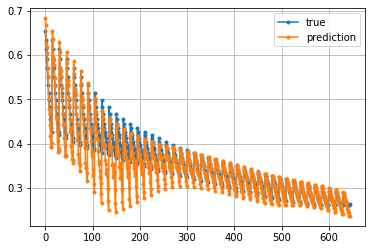

TEST FR-A
MSE =  0.0025360846677056764
MAE =  0.03998629628120678


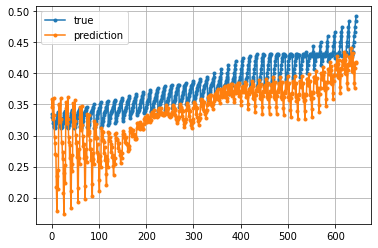

TEST FR-B
MSE =  0.006389340946089239
MAE =  0.06495097661616538


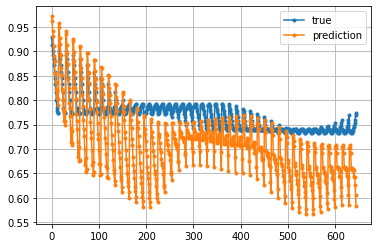

TEST FR-C
MSE =  0.008849899837096543
MAE =  0.08037282120731847


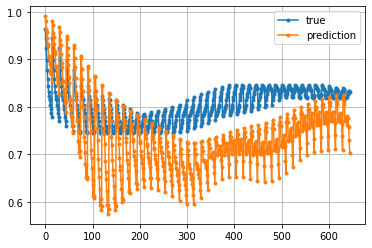

TEST FR-J
MSE =  0.0007871656240953072
MAE =  0.02355984202490225


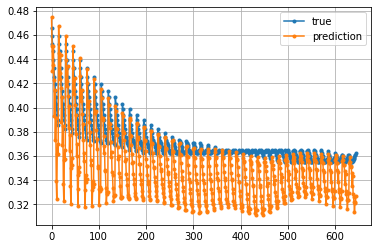

In [28]:
"""for loc in train_datapoints:
    print("TRAINING", loc)
    x, y = train_datapoints[loc]
    yp = model.predict(x)

    plt.plot(y.reshape(-1), label='true')
    plt.plot(yp.reshape(-1), label='prediction')
    plt.legend()
    plt.grid()
    plt.show()
    
for loc in valid_datapoints:
    print("VALIDATION", loc)
    x, y = valid_datapoints[loc]
    yp = model.predict(x)

    plt.plot(y.reshape(-1), label='true')
    plt.plot(yp.reshape(-1), label='prediction')
    plt.legend()
    plt.grid()
    plt.show()"""

for loc in test_datapoints:
    MSE = 0
    MAE = 0
    print("TEST", loc)
    x, y = test_datapoints[loc]
    yp = model.predict(x)
    MSE = mean_squared_error(y.reshape(-1), yp.reshape(-1))
    MAE = mean_absolute_error(y.reshape(-1), yp.reshape(-1))
    print("MSE = ", MSE)
    print("MAE = ", MAE)
    plt.plot(y.reshape(-1), label='true', marker=".")
    plt.plot(yp.reshape(-1), label='prediction', marker=".")
    plt.legend()
    plt.grid()
    plt.show()

In [54]:
def error_set(models, points, plot=False, mode='train'):
    """
    compute the MAE and MSE on the models given, on all possible horizon
    :param models: dict of models to evaluate
    :param points: dict of {loc: [x,y]} to use to compute the error
    :param plot: whether to plot the predictions or not
    :param mode: one of ['train', 'valid', 'test']. Used to deduce the index of the datapoints, needed
        to show the dates in the plot. No effect if plot=False
    :return df_errors: dataframe with one pair of [MSE, MAE] columns for each horizon and each entry line per model
    """
    y_predicted = {k: {loc: None for loc in points} for k in models.keys()}
    y_true = {loc: None for loc in points}
    if plot:
        if mode == 'train':
            idx = train_idx
        elif mode == 'valid':
            idx = valid_idx
        elif mode == 'test':
            idx = test_idx
    for loc in points:
        print(loc)
        x, y = points[loc]
        y_true[loc] = y
        for name, model in models.items():
            yp = model.predict(x)
            if plot:
                plot_prediction_vs_actual(yp, idx, loc, show_fit=0)
                plt.title(f'{name} model: {mode} set using {loc}')
            y_predicted[name][loc] = yp
    MSE = {}
    MAE = {}
    for i in range(n_forecast):
        MSE[f'MSE (t+{i+1})'] = []
        MAE[f'MAE (t+{i+1})'] = []
        models_names = []
        y_true_horizon = np.array([l[:,i] for l in y_true.values()]).reshape(-1)
        for k in models.keys():
            models_names.append(k)
            y_predicted_horizon = np.array([l[:,i] for l in y_predicted[k].values()]).reshape(-1)
            MSE[f'MSE (t+{i+1})'].append(mean_squared_error(y_true_horizon, y_predicted_horizon))
            MAE[f'MAE (t+{i+1})'].append(mean_absolute_error(y_true_horizon, y_predicted_horizon))
        #df_errors[i+1] = pd.DataFrame(data={'Model': models_names, 'MSE': MSE, 'MAE': MAE}).set_index('Model').sort_values(by=['MSE'])
    data = {'Model': models_names, **MSE, **MAE}
    df_errors = pd.DataFrame(data=data).set_index('Model').sort_values(by=['MSE (t+1)'])
    # order with respect to the time
    columns = df_errors.columns.to_list()
    columns.sort(key = lambda x: int(re.search("\(t\+(\d+)\)", x).group(1)))
    df_errors = df_errors[columns]
    return df_errors

### Let's use the validation set

In [51]:
import keras.backend as K
def custom_loss_function(y_true, y_pred):
    extra = y_true[:, 1:]
    print(extra)
    return K.sum(K.abs(y_true - y_pred))**2

def run_model(x_train, y_train, x_val, y_val, p):
    model = Sequential()
    model.add(LSTM(32, input_shape=(n_samples, n_features), 
                   return_sequences=True, kernel_regularizer=p['reg'](p['regw']),
                  dropout=p['dropout'], recurrent_dropout=p['recurrent_dropout']))
    model.add(LSTM(32, input_shape=(n_samples, n_features), 
                   return_sequences=False, kernel_regularizer=p['reg'](p['regw']),
                  dropout=p['dropout'], recurrent_dropout=p['recurrent_dropout']))
    model.add(Dense(n_forecast, kernel_regularizer=p['reg'](p['regw']), 
                        activation=p['activation']))
    LSTMModel = model
    
    model.compile(loss=p["losses"], optimizer=p["optimizer"], metrics=['mae', 'mse'])
    history = model.fit(train_generator(), steps_per_epoch=len(train_datapoints), epochs=p["epochs"], 
                        verbose=0, shuffle=False, 
                        validation_data=validation_generator(), validation_steps=len(valid_datapoints))
    
    return history, model
    

p = {'activation':['relu'],
     'reg': [lambda x: regularizers.l2(l=x), lambda x: regularizers.l1(l=x), lambda x: None],
     'regw': [1e-4, 5e-4, 1e-3],
     'optimizer': ['Adam'],
     'losses': ['mae', 'mse'],
     'epochs': [5000, 7000, 10000],
     'dropout': [0, 0.1, 0.2],
     'recurrent_dropout': [0, 0.1, 0.2]
}

scan_object = talos.Scan(
    x=[],
    y=[],
    x_val=[],
    y_val=[],
    params=p,
    model=run_model,
    experiment_name='trends1', 
    fraction_limit=0.01
)


100%|██████████| 4/4 [1:34:21<00:00, 1415.41s/it]


In [52]:
analyze_object = talos.Analyze(scan_object)
print("MAE", analyze_object.low('mae'))
print("MSE", analyze_object.low('mse'))
print("VAL MAE", analyze_object.low('val_mae'))
print("VAL MSE", analyze_object.low('val_mse'))
analyze_object.table('val_mse', exclude=[], ascending=True)

MAE 0.007651109714061022
MSE 0.00014150276547297835
VAL MAE 0.1163816750049591
VAL MSE 0.027700722217559814


,val_loss,optimizer,losses,mae,activation,start,recurrent_dropout,regw,epochs,mse,dropout,loss,end,duration,val_mae,round_epochs,reg,val_mse
3,0.117594,Adam,mae,0.007651,relu,01/27/21-152806,0.1,0.0001,7000,0.000142,0.0,0.008867,01/27/21-155613,1686.697120,0.116382,7000,<function <lambda> at 0x7feaf8cc89d0>,0.027701
0,0.061849,Adam,mse,0.016989,relu,01/27/21-142201,0.0,0.0001,5000,0.000488,0.1,0.001604,01/27/21-143343,701.751494,0.184260,5000,<function <lambda> at 0x7feadd68bb80>,0.060746
2,0.066469,Adam,mse,0.010315,relu,01/27/21-145616,0.1,0.0005,7000,0.000183,0.2,0.000183,01/27/21-152749,1892.757026,0.202092,7000,<function <lambda> at 0x7feadd68b820>,0.066469
1,0.082754,Adam,mse,0.012232,relu,01/27/21-143344,0.0,0.0001,10000,0.000266,0.1,0.001225,01/27/21-145607,1342.812933,0.207817,10000,<function <lambda> at 0x7feadd68bb80>,0.081807


BE
FR-A
FR-B
FR-C
FR-J


,MSE (t+1),MAE (t+1),MSE (t+2),MAE (t+2),MSE (t+3),MAE (t+3),MSE (t+4),MAE (t+4),MSE (t+5),MAE (t+5),...,MSE (t+11),MAE (t+11),MSE (t+12),MAE (t+12),MSE (t+13),MAE (t+13),MSE (t+14),MAE (t+14),MSE (t+15),MAE (t+15)
Model,,,,,,,,,,,,,,,,,,,,,
LSTM tuned,0.00074,0.022914,0.001084,0.026965,0.001676,0.033603,0.002221,0.038368,0.002819,0.043022,...,0.009393,0.082837,0.010779,0.089192,0.012972,0.09789,0.014744,0.103936,0.016522,0.109745


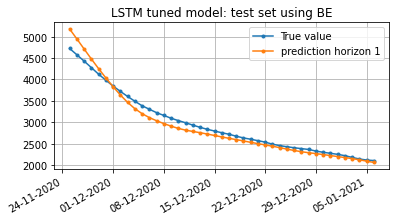

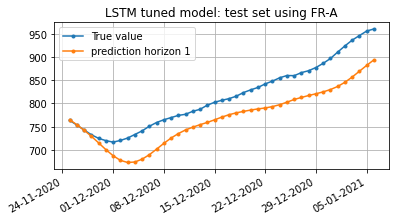

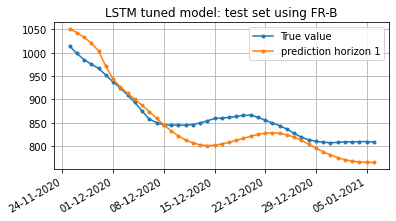

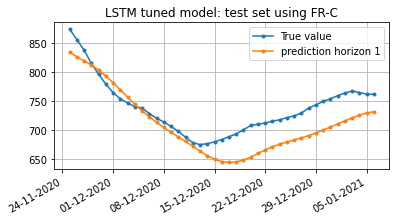

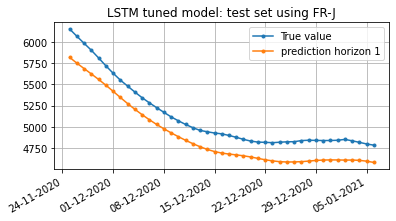

In [57]:
best_model = scan_object.best_model('val_mse', asc=True)
error_set({'LSTM tuned': best_model}, test_datapoints, plot=True, mode='test')

## Base line models
### MultiStepLastBaseline
This model repeats the last value of hospitalisations `n_forecast` time

In [58]:
class MultiStepLastBaseline(tf.keras.Model):
    """
    repeat the last hospitalisations given as input n_forecast time
    """
    def call(self, inputs):
        a = inputs[:, -1:, target_idx:target_idx+1]  # target of the last days
        return tf.tile(
            a,
            [1, n_forecast, 1]   # repeat target n_forecast time
        )

BaselineModel = MultiStepLastBaseline()
BaselineModel.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

## Linear regression
linear regression of the last `n_sample` days used to predict the next `n_forecast` days

In [59]:
class LinearRegressionHospi(tf.keras.Model):
    """
    repeat the last hospitalisations given as input n_forecast time
    """
    def predict(self, inputs):
        y = inputs[:, :, target_idx]  # target of the last days
        length = len(inputs)
        x = np.arange(n_samples).reshape(-1,1)  # dates of the target
        result = np.zeros((length, n_forecast))
        for i in range(length):
            regr = LinearRegression().fit(x,y[i])  # linear regression of (days, target)
            result[i] = regr.predict(np.arange(n_samples, n_samples+n_forecast).reshape(-1,1))
        return result
        

## 1 fully connected layer (Dense model)

In [60]:
DenseModel = Sequential()
DenseModel.add(Lambda(lambda x: x[:,:,target_idx]))  # select only the target of the previous days
DenseModel.add(Dense(n_forecast))   # predict the next target based on the previous ones
DenseModel.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

In [61]:
LinearModel_history = DenseModel.fit(train_generator(), steps_per_epoch=len(train_datapoints), epochs=epochs, verbose=1, shuffle=False, 
          validation_data=validation_generator(),
          validation_steps=len(valid_datapoints))

Epoch 1/2800
5/5 [==============================] - 0s 21ms/step - loss: 0.1122 - mean_absolute_error: 0.1888 - val_loss: 0.3486 - val_mean_absolute_error: 0.4549
Epoch 2/2800
5/5 [==============================] - 0s 9ms/step - loss: 0.0837 - mean_absolute_error: 0.1565 - val_loss: 0.3089 - val_mean_absolute_error: 0.4249
Epoch 3/2800
5/5 [==============================] - 0s 9ms/step - loss: 0.0678 - mean_absolute_error: 0.1377 - val_loss: 0.2796 - val_mean_absolute_error: 0.4019
Epoch 4/2800
5/5 [==============================] - 0s 9ms/step - loss: 0.0560 - mean_absolute_error: 0.1226 - val_loss: 0.2556 - val_mean_absolute_error: 0.3825
Epoch 5/2800
5/5 [==============================] - 0s 9ms/step - loss: 0.0467 - mean_absolute_error: 0.1100 - val_loss: 0.2350 - val_mean_absolute_error: 0.3654
Epoch 6/2800
5/5 [==============================] - 0s 9ms/step - loss: 0.0390 - mean_absolute_error: 0.0993 - val_loss: 0.2171 - val_mean_absolute_error: 0.3500
Epoch 7/2800
5/5 [=========

5/5 [==============================] - 0s 7ms/step - loss: 0.0021 - mean_absolute_error: 0.0286 - val_loss: 0.0730 - val_mean_absolute_error: 0.1945
Epoch 52/2800
5/5 [==============================] - 0s 7ms/step - loss: 0.0021 - mean_absolute_error: 0.0284 - val_loss: 0.0725 - val_mean_absolute_error: 0.1937
Epoch 53/2800
5/5 [==============================] - 0s 7ms/step - loss: 0.0020 - mean_absolute_error: 0.0282 - val_loss: 0.0720 - val_mean_absolute_error: 0.1929
Epoch 54/2800
5/5 [==============================] - 0s 7ms/step - loss: 0.0020 - mean_absolute_error: 0.0281 - val_loss: 0.0716 - val_mean_absolute_error: 0.1922
Epoch 55/2800
5/5 [==============================] - 0s 8ms/step - loss: 0.0020 - mean_absolute_error: 0.0279 - val_loss: 0.0711 - val_mean_absolute_error: 0.1915
Epoch 56/2800
5/5 [==============================] - 0s 7ms/step - loss: 0.0019 - mean_absolute_error: 0.0278 - val_loss: 0.0707 - val_mean_absolute_error: 0.1908
Epoch 57/2800
5/5 [=================

5/5 [==============================] - 0s 8ms/step - loss: 0.0016 - mean_absolute_error: 0.0260 - val_loss: 0.0618 - val_mean_absolute_error: 0.1767
Epoch 102/2800
5/5 [==============================] - 0s 8ms/step - loss: 0.0016 - mean_absolute_error: 0.0259 - val_loss: 0.0617 - val_mean_absolute_error: 0.1766
Epoch 103/2800
5/5 [==============================] - 0s 8ms/step - loss: 0.0016 - mean_absolute_error: 0.0259 - val_loss: 0.0616 - val_mean_absolute_error: 0.1764
Epoch 104/2800
5/5 [==============================] - 0s 8ms/step - loss: 0.0016 - mean_absolute_error: 0.0259 - val_loss: 0.0616 - val_mean_absolute_error: 0.1763
Epoch 105/2800
5/5 [==============================] - 0s 8ms/step - loss: 0.0016 - mean_absolute_error: 0.0259 - val_loss: 0.0615 - val_mean_absolute_error: 0.1761
Epoch 106/2800
5/5 [==============================] - 0s 7ms/step - loss: 0.0016 - mean_absolute_error: 0.0259 - val_loss: 0.0614 - val_mean_absolute_error: 0.1760
Epoch 107/2800
5/5 [===========

5/5 [==============================] - 0s 10ms/step - loss: 0.0015 - mean_absolute_error: 0.0253 - val_loss: 0.0586 - val_mean_absolute_error: 0.1714
Epoch 152/2800
5/5 [==============================] - 0s 8ms/step - loss: 0.0015 - mean_absolute_error: 0.0253 - val_loss: 0.0585 - val_mean_absolute_error: 0.1713
Epoch 153/2800
5/5 [==============================] - 0s 7ms/step - loss: 0.0015 - mean_absolute_error: 0.0253 - val_loss: 0.0585 - val_mean_absolute_error: 0.1712
Epoch 154/2800
5/5 [==============================] - 0s 7ms/step - loss: 0.0015 - mean_absolute_error: 0.0253 - val_loss: 0.0584 - val_mean_absolute_error: 0.1711
Epoch 155/2800
5/5 [==============================] - 0s 8ms/step - loss: 0.0015 - mean_absolute_error: 0.0253 - val_loss: 0.0584 - val_mean_absolute_error: 0.1710
Epoch 156/2800
5/5 [==============================] - 0s 8ms/step - loss: 0.0015 - mean_absolute_error: 0.0253 - val_loss: 0.0583 - val_mean_absolute_error: 0.1710
Epoch 157/2800
5/5 [==========

5/5 [==============================] - 0s 8ms/step - loss: 0.0014 - mean_absolute_error: 0.0247 - val_loss: 0.0562 - val_mean_absolute_error: 0.1674
Epoch 202/2800
5/5 [==============================] - 0s 7ms/step - loss: 0.0014 - mean_absolute_error: 0.0247 - val_loss: 0.0561 - val_mean_absolute_error: 0.1673
Epoch 203/2800
5/5 [==============================] - 0s 8ms/step - loss: 0.0014 - mean_absolute_error: 0.0247 - val_loss: 0.0561 - val_mean_absolute_error: 0.1672
Epoch 204/2800
5/5 [==============================] - 0s 8ms/step - loss: 0.0014 - mean_absolute_error: 0.0247 - val_loss: 0.0560 - val_mean_absolute_error: 0.1672
Epoch 205/2800
5/5 [==============================] - 0s 8ms/step - loss: 0.0014 - mean_absolute_error: 0.0247 - val_loss: 0.0560 - val_mean_absolute_error: 0.1671
Epoch 206/2800
5/5 [==============================] - 0s 9ms/step - loss: 0.0014 - mean_absolute_error: 0.0247 - val_loss: 0.0560 - val_mean_absolute_error: 0.1670
Epoch 207/2800
5/5 [===========

5/5 [==============================] - 0s 8ms/step - loss: 0.0014 - mean_absolute_error: 0.0241 - val_loss: 0.0540 - val_mean_absolute_error: 0.1637
Epoch 252/2800
5/5 [==============================] - 0s 8ms/step - loss: 0.0014 - mean_absolute_error: 0.0241 - val_loss: 0.0540 - val_mean_absolute_error: 0.1636
Epoch 253/2800
5/5 [==============================] - 0s 8ms/step - loss: 0.0014 - mean_absolute_error: 0.0241 - val_loss: 0.0539 - val_mean_absolute_error: 0.1635
Epoch 254/2800
5/5 [==============================] - 0s 9ms/step - loss: 0.0014 - mean_absolute_error: 0.0241 - val_loss: 0.0539 - val_mean_absolute_error: 0.1635
Epoch 255/2800
5/5 [==============================] - 0s 9ms/step - loss: 0.0014 - mean_absolute_error: 0.0241 - val_loss: 0.0538 - val_mean_absolute_error: 0.1634
Epoch 256/2800
5/5 [==============================] - 0s 8ms/step - loss: 0.0014 - mean_absolute_error: 0.0241 - val_loss: 0.0538 - val_mean_absolute_error: 0.1633
Epoch 257/2800
5/5 [===========

5/5 [==============================] - 0s 8ms/step - loss: 0.0013 - mean_absolute_error: 0.0236 - val_loss: 0.0520 - val_mean_absolute_error: 0.1601
Epoch 302/2800
5/5 [==============================] - 0s 8ms/step - loss: 0.0013 - mean_absolute_error: 0.0236 - val_loss: 0.0519 - val_mean_absolute_error: 0.1600
Epoch 303/2800
5/5 [==============================] - 0s 8ms/step - loss: 0.0013 - mean_absolute_error: 0.0236 - val_loss: 0.0519 - val_mean_absolute_error: 0.1599
Epoch 304/2800
5/5 [==============================] - 0s 8ms/step - loss: 0.0013 - mean_absolute_error: 0.0236 - val_loss: 0.0518 - val_mean_absolute_error: 0.1599
Epoch 305/2800
5/5 [==============================] - 0s 8ms/step - loss: 0.0013 - mean_absolute_error: 0.0235 - val_loss: 0.0518 - val_mean_absolute_error: 0.1598
Epoch 306/2800
5/5 [==============================] - 0s 8ms/step - loss: 0.0013 - mean_absolute_error: 0.0235 - val_loss: 0.0518 - val_mean_absolute_error: 0.1597
Epoch 307/2800
5/5 [===========

Epoch 351/2800
5/5 [==============================] - 0s 7ms/step - loss: 0.0013 - mean_absolute_error: 0.0231 - val_loss: 0.0500 - val_mean_absolute_error: 0.1566
Epoch 352/2800
5/5 [==============================] - 0s 7ms/step - loss: 0.0013 - mean_absolute_error: 0.0230 - val_loss: 0.0500 - val_mean_absolute_error: 0.1565
Epoch 353/2800
5/5 [==============================] - 0s 7ms/step - loss: 0.0013 - mean_absolute_error: 0.0230 - val_loss: 0.0499 - val_mean_absolute_error: 0.1565
Epoch 354/2800
5/5 [==============================] - 0s 8ms/step - loss: 0.0013 - mean_absolute_error: 0.0230 - val_loss: 0.0499 - val_mean_absolute_error: 0.1564
Epoch 355/2800
5/5 [==============================] - 0s 8ms/step - loss: 0.0013 - mean_absolute_error: 0.0230 - val_loss: 0.0499 - val_mean_absolute_error: 0.1563
Epoch 356/2800
5/5 [==============================] - 0s 8ms/step - loss: 0.0013 - mean_absolute_error: 0.0230 - val_loss: 0.0498 - val_mean_absolute_error: 0.1562
Epoch 357/2800
5

Epoch 401/2800
5/5 [==============================] - 0s 7ms/step - loss: 0.0012 - mean_absolute_error: 0.0225 - val_loss: 0.0482 - val_mean_absolute_error: 0.1532
Epoch 402/2800
5/5 [==============================] - 0s 8ms/step - loss: 0.0012 - mean_absolute_error: 0.0225 - val_loss: 0.0481 - val_mean_absolute_error: 0.1532
Epoch 403/2800
5/5 [==============================] - 0s 8ms/step - loss: 0.0012 - mean_absolute_error: 0.0225 - val_loss: 0.0481 - val_mean_absolute_error: 0.1531
Epoch 404/2800
5/5 [==============================] - 0s 8ms/step - loss: 0.0012 - mean_absolute_error: 0.0225 - val_loss: 0.0481 - val_mean_absolute_error: 0.1530
Epoch 405/2800
5/5 [==============================] - 0s 8ms/step - loss: 0.0012 - mean_absolute_error: 0.0225 - val_loss: 0.0480 - val_mean_absolute_error: 0.1530
Epoch 406/2800
5/5 [==============================] - 0s 8ms/step - loss: 0.0012 - mean_absolute_error: 0.0225 - val_loss: 0.0480 - val_mean_absolute_error: 0.1529
Epoch 407/2800
5

Epoch 451/2800
5/5 [==============================] - 0s 8ms/step - loss: 0.0012 - mean_absolute_error: 0.0221 - val_loss: 0.0464 - val_mean_absolute_error: 0.1500
Epoch 452/2800
5/5 [==============================] - 0s 8ms/step - loss: 0.0012 - mean_absolute_error: 0.0221 - val_loss: 0.0464 - val_mean_absolute_error: 0.1499
Epoch 453/2800
5/5 [==============================] - 0s 8ms/step - loss: 0.0012 - mean_absolute_error: 0.0221 - val_loss: 0.0464 - val_mean_absolute_error: 0.1499
Epoch 454/2800
5/5 [==============================] - 0s 7ms/step - loss: 0.0012 - mean_absolute_error: 0.0220 - val_loss: 0.0463 - val_mean_absolute_error: 0.1498
Epoch 455/2800
5/5 [==============================] - 0s 8ms/step - loss: 0.0012 - mean_absolute_error: 0.0220 - val_loss: 0.0463 - val_mean_absolute_error: 0.1498
Epoch 456/2800
5/5 [==============================] - 0s 8ms/step - loss: 0.0012 - mean_absolute_error: 0.0220 - val_loss: 0.0463 - val_mean_absolute_error: 0.1497
Epoch 457/2800
5

Epoch 501/2800
5/5 [==============================] - 0s 10ms/step - loss: 0.0011 - mean_absolute_error: 0.0216 - val_loss: 0.0448 - val_mean_absolute_error: 0.1469
Epoch 502/2800
5/5 [==============================] - 0s 9ms/step - loss: 0.0011 - mean_absolute_error: 0.0216 - val_loss: 0.0448 - val_mean_absolute_error: 0.1468
Epoch 503/2800
5/5 [==============================] - 0s 11ms/step - loss: 0.0011 - mean_absolute_error: 0.0216 - val_loss: 0.0447 - val_mean_absolute_error: 0.1468
Epoch 504/2800
5/5 [==============================] - 0s 10ms/step - loss: 0.0011 - mean_absolute_error: 0.0216 - val_loss: 0.0447 - val_mean_absolute_error: 0.1467
Epoch 505/2800
5/5 [==============================] - 0s 11ms/step - loss: 0.0011 - mean_absolute_error: 0.0216 - val_loss: 0.0447 - val_mean_absolute_error: 0.1467
Epoch 506/2800
5/5 [==============================] - 0s 13ms/step - loss: 0.0011 - mean_absolute_error: 0.0216 - val_loss: 0.0446 - val_mean_absolute_error: 0.1466
Epoch 507/2

Epoch 551/2800
5/5 [==============================] - 0s 8ms/step - loss: 0.0011 - mean_absolute_error: 0.0212 - val_loss: 0.0432 - val_mean_absolute_error: 0.1439
Epoch 552/2800
5/5 [==============================] - 0s 9ms/step - loss: 0.0011 - mean_absolute_error: 0.0212 - val_loss: 0.0432 - val_mean_absolute_error: 0.1439
Epoch 553/2800
5/5 [==============================] - 0s 8ms/step - loss: 0.0011 - mean_absolute_error: 0.0212 - val_loss: 0.0432 - val_mean_absolute_error: 0.1438
Epoch 554/2800
5/5 [==============================] - 0s 9ms/step - loss: 0.0011 - mean_absolute_error: 0.0212 - val_loss: 0.0431 - val_mean_absolute_error: 0.1437
Epoch 555/2800
5/5 [==============================] - 0s 7ms/step - loss: 0.0011 - mean_absolute_error: 0.0212 - val_loss: 0.0431 - val_mean_absolute_error: 0.1437
Epoch 556/2800
5/5 [==============================] - 0s 8ms/step - loss: 0.0011 - mean_absolute_error: 0.0212 - val_loss: 0.0431 - val_mean_absolute_error: 0.1436
Epoch 557/2800
5

Epoch 601/2800
5/5 [==============================] - 0s 8ms/step - loss: 0.0010 - mean_absolute_error: 0.0208 - val_loss: 0.0418 - val_mean_absolute_error: 0.1410
Epoch 602/2800
5/5 [==============================] - 0s 8ms/step - loss: 0.0010 - mean_absolute_error: 0.0208 - val_loss: 0.0418 - val_mean_absolute_error: 0.1410
Epoch 603/2800
5/5 [==============================] - 0s 8ms/step - loss: 0.0010 - mean_absolute_error: 0.0208 - val_loss: 0.0417 - val_mean_absolute_error: 0.1409
Epoch 604/2800
5/5 [==============================] - 0s 7ms/step - loss: 0.0010 - mean_absolute_error: 0.0208 - val_loss: 0.0417 - val_mean_absolute_error: 0.1409
Epoch 605/2800
5/5 [==============================] - 0s 7ms/step - loss: 0.0010 - mean_absolute_error: 0.0207 - val_loss: 0.0417 - val_mean_absolute_error: 0.1408
Epoch 606/2800
5/5 [==============================] - 0s 7ms/step - loss: 0.0010 - mean_absolute_error: 0.0208 - val_loss: 0.0416 - val_mean_absolute_error: 0.1408
Epoch 607/2800
5

Epoch 651/2800
5/5 [==============================] - 0s 7ms/step - loss: 9.9579e-04 - mean_absolute_error: 0.0204 - val_loss: 0.0404 - val_mean_absolute_error: 0.1383
Epoch 652/2800
5/5 [==============================] - 0s 8ms/step - loss: 9.9587e-04 - mean_absolute_error: 0.0204 - val_loss: 0.0404 - val_mean_absolute_error: 0.1383
Epoch 653/2800
5/5 [==============================] - 0s 7ms/step - loss: 9.9437e-04 - mean_absolute_error: 0.0204 - val_loss: 0.0404 - val_mean_absolute_error: 0.1382
Epoch 654/2800
5/5 [==============================] - 0s 8ms/step - loss: 9.9447e-04 - mean_absolute_error: 0.0204 - val_loss: 0.0403 - val_mean_absolute_error: 0.1382
Epoch 655/2800
5/5 [==============================] - 0s 7ms/step - loss: 9.9297e-04 - mean_absolute_error: 0.0204 - val_loss: 0.0403 - val_mean_absolute_error: 0.1381
Epoch 656/2800
5/5 [==============================] - 0s 8ms/step - loss: 9.9307e-04 - mean_absolute_error: 0.0204 - val_loss: 0.0403 - val_mean_absolute_error:

Epoch 700/2800
5/5 [==============================] - 0s 7ms/step - loss: 9.6327e-04 - mean_absolute_error: 0.0201 - val_loss: 0.0391 - val_mean_absolute_error: 0.1358
Epoch 701/2800
5/5 [==============================] - 0s 7ms/step - loss: 9.6174e-04 - mean_absolute_error: 0.0200 - val_loss: 0.0391 - val_mean_absolute_error: 0.1357
Epoch 702/2800
5/5 [==============================] - 0s 8ms/step - loss: 9.6196e-04 - mean_absolute_error: 0.0201 - val_loss: 0.0391 - val_mean_absolute_error: 0.1357
Epoch 703/2800
5/5 [==============================] - 0s 8ms/step - loss: 9.6043e-04 - mean_absolute_error: 0.0200 - val_loss: 0.0391 - val_mean_absolute_error: 0.1356
Epoch 704/2800
5/5 [==============================] - 0s 8ms/step - loss: 9.6066e-04 - mean_absolute_error: 0.0201 - val_loss: 0.0390 - val_mean_absolute_error: 0.1356
Epoch 705/2800
5/5 [==============================] - 0s 9ms/step - loss: 9.5913e-04 - mean_absolute_error: 0.0200 - val_loss: 0.0390 - val_mean_absolute_error:

Epoch 749/2800
5/5 [==============================] - 0s 7ms/step - loss: 9.3136e-04 - mean_absolute_error: 0.0197 - val_loss: 0.0379 - val_mean_absolute_error: 0.1333
Epoch 750/2800
5/5 [==============================] - 0s 7ms/step - loss: 9.3169e-04 - mean_absolute_error: 0.0198 - val_loss: 0.0379 - val_mean_absolute_error: 0.1334
Epoch 751/2800
5/5 [==============================] - 0s 7ms/step - loss: 9.3014e-04 - mean_absolute_error: 0.0197 - val_loss: 0.0379 - val_mean_absolute_error: 0.1332
Epoch 752/2800
5/5 [==============================] - 0s 9ms/step - loss: 9.3047e-04 - mean_absolute_error: 0.0198 - val_loss: 0.0379 - val_mean_absolute_error: 0.1333
Epoch 753/2800
5/5 [==============================] - 0s 8ms/step - loss: 9.2893e-04 - mean_absolute_error: 0.0197 - val_loss: 0.0379 - val_mean_absolute_error: 0.1331
Epoch 754/2800
5/5 [==============================] - 0s 7ms/step - loss: 9.2926e-04 - mean_absolute_error: 0.0197 - val_loss: 0.0378 - val_mean_absolute_error:

Epoch 798/2800
5/5 [==============================] - 0s 8ms/step - loss: 9.0351e-04 - mean_absolute_error: 0.0195 - val_loss: 0.0368 - val_mean_absolute_error: 0.1311
Epoch 799/2800
5/5 [==============================] - 0s 8ms/step - loss: 9.0196e-04 - mean_absolute_error: 0.0194 - val_loss: 0.0368 - val_mean_absolute_error: 0.1309
Epoch 800/2800
5/5 [==============================] - 0s 7ms/step - loss: 9.0238e-04 - mean_absolute_error: 0.0195 - val_loss: 0.0368 - val_mean_absolute_error: 0.1310
Epoch 801/2800
5/5 [==============================] - 0s 7ms/step - loss: 9.0083e-04 - mean_absolute_error: 0.0194 - val_loss: 0.0368 - val_mean_absolute_error: 0.1309
Epoch 802/2800
5/5 [==============================] - 0s 8ms/step - loss: 9.0125e-04 - mean_absolute_error: 0.0195 - val_loss: 0.0368 - val_mean_absolute_error: 0.1309
Epoch 803/2800
5/5 [==============================] - 0s 7ms/step - loss: 8.9970e-04 - mean_absolute_error: 0.0194 - val_loss: 0.0367 - val_mean_absolute_error:

Epoch 847/2800
5/5 [==============================] - 0s 7ms/step - loss: 8.7576e-04 - mean_absolute_error: 0.0192 - val_loss: 0.0358 - val_mean_absolute_error: 0.1288
Epoch 848/2800
5/5 [==============================] - 0s 7ms/step - loss: 8.7626e-04 - mean_absolute_error: 0.0192 - val_loss: 0.0358 - val_mean_absolute_error: 0.1289
Epoch 849/2800
5/5 [==============================] - 0s 7ms/step - loss: 8.7471e-04 - mean_absolute_error: 0.0191 - val_loss: 0.0357 - val_mean_absolute_error: 0.1287
Epoch 850/2800
5/5 [==============================] - 0s 8ms/step - loss: 8.7521e-04 - mean_absolute_error: 0.0192 - val_loss: 0.0357 - val_mean_absolute_error: 0.1288
Epoch 851/2800
5/5 [==============================] - 0s 7ms/step - loss: 8.7367e-04 - mean_absolute_error: 0.0191 - val_loss: 0.0357 - val_mean_absolute_error: 0.1287
Epoch 852/2800
5/5 [==============================] - 0s 7ms/step - loss: 8.7416e-04 - mean_absolute_error: 0.0192 - val_loss: 0.0357 - val_mean_absolute_error:

Epoch 896/2800
5/5 [==============================] - 0s 8ms/step - loss: 8.5198e-04 - mean_absolute_error: 0.0190 - val_loss: 0.0348 - val_mean_absolute_error: 0.1269
Epoch 897/2800
5/5 [==============================] - 0s 8ms/step - loss: 8.5045e-04 - mean_absolute_error: 0.0189 - val_loss: 0.0348 - val_mean_absolute_error: 0.1267
Epoch 898/2800
5/5 [==============================] - 0s 9ms/step - loss: 8.5101e-04 - mean_absolute_error: 0.0190 - val_loss: 0.0348 - val_mean_absolute_error: 0.1268
Epoch 899/2800
5/5 [==============================] - 0s 9ms/step - loss: 8.4947e-04 - mean_absolute_error: 0.0189 - val_loss: 0.0347 - val_mean_absolute_error: 0.1267
Epoch 900/2800
5/5 [==============================] - 0s 8ms/step - loss: 8.5003e-04 - mean_absolute_error: 0.0189 - val_loss: 0.0347 - val_mean_absolute_error: 0.1268
Epoch 901/2800
5/5 [==============================] - 0s 8ms/step - loss: 8.4850e-04 - mean_absolute_error: 0.0189 - val_loss: 0.0347 - val_mean_absolute_error:

Epoch 945/2800
5/5 [==============================] - 0s 8ms/step - loss: 8.2789e-04 - mean_absolute_error: 0.0187 - val_loss: 0.0339 - val_mean_absolute_error: 0.1248
Epoch 946/2800
5/5 [==============================] - 0s 8ms/step - loss: 8.2851e-04 - mean_absolute_error: 0.0187 - val_loss: 0.0339 - val_mean_absolute_error: 0.1249
Epoch 947/2800
5/5 [==============================] - 0s 7ms/step - loss: 8.2698e-04 - mean_absolute_error: 0.0187 - val_loss: 0.0338 - val_mean_absolute_error: 0.1248
Epoch 948/2800
5/5 [==============================] - 0s 8ms/step - loss: 8.2760e-04 - mean_absolute_error: 0.0187 - val_loss: 0.0338 - val_mean_absolute_error: 0.1249
Epoch 949/2800
5/5 [==============================] - 0s 7ms/step - loss: 8.2608e-04 - mean_absolute_error: 0.0187 - val_loss: 0.0338 - val_mean_absolute_error: 0.1247
Epoch 950/2800
5/5 [==============================] - 0s 8ms/step - loss: 8.2670e-04 - mean_absolute_error: 0.0187 - val_loss: 0.0338 - val_mean_absolute_error:

Epoch 994/2800
5/5 [==============================] - 0s 7ms/step - loss: 8.0757e-04 - mean_absolute_error: 0.0185 - val_loss: 0.0330 - val_mean_absolute_error: 0.1232
Epoch 995/2800
5/5 [==============================] - 0s 7ms/step - loss: 8.0606e-04 - mean_absolute_error: 0.0184 - val_loss: 0.0330 - val_mean_absolute_error: 0.1230
Epoch 996/2800
5/5 [==============================] - 0s 8ms/step - loss: 8.0673e-04 - mean_absolute_error: 0.0185 - val_loss: 0.0330 - val_mean_absolute_error: 0.1231
Epoch 997/2800
5/5 [==============================] - 0s 7ms/step - loss: 8.0522e-04 - mean_absolute_error: 0.0184 - val_loss: 0.0330 - val_mean_absolute_error: 0.1229
Epoch 998/2800
5/5 [==============================] - 0s 7ms/step - loss: 8.0589e-04 - mean_absolute_error: 0.0185 - val_loss: 0.0330 - val_mean_absolute_error: 0.1230
Epoch 999/2800
5/5 [==============================] - 0s 8ms/step - loss: 8.0438e-04 - mean_absolute_error: 0.0184 - val_loss: 0.0329 - val_mean_absolute_error:

5/5 [==============================] - 0s 7ms/step - loss: 7.8806e-04 - mean_absolute_error: 0.0183 - val_loss: 0.0322 - val_mean_absolute_error: 0.1215
Epoch 1043/2800
5/5 [==============================] - 0s 7ms/step - loss: 7.8656e-04 - mean_absolute_error: 0.0182 - val_loss: 0.0322 - val_mean_absolute_error: 0.1213
Epoch 1044/2800
5/5 [==============================] - 0s 7ms/step - loss: 7.8727e-04 - mean_absolute_error: 0.0183 - val_loss: 0.0322 - val_mean_absolute_error: 0.1214
Epoch 1045/2800
5/5 [==============================] - 0s 7ms/step - loss: 7.8578e-04 - mean_absolute_error: 0.0182 - val_loss: 0.0322 - val_mean_absolute_error: 0.1212
Epoch 1046/2800
5/5 [==============================] - 0s 8ms/step - loss: 7.8649e-04 - mean_absolute_error: 0.0183 - val_loss: 0.0322 - val_mean_absolute_error: 0.1213
Epoch 1047/2800
5/5 [==============================] - 0s 8ms/step - loss: 7.8499e-04 - mean_absolute_error: 0.0182 - val_loss: 0.0321 - val_mean_absolute_error: 0.1211
Ep

5/5 [==============================] - 0s 7ms/step - loss: 7.6985e-04 - mean_absolute_error: 0.0181 - val_loss: 0.0315 - val_mean_absolute_error: 0.1199
Epoch 1091/2800
5/5 [==============================] - 0s 7ms/step - loss: 7.6836e-04 - mean_absolute_error: 0.0180 - val_loss: 0.0314 - val_mean_absolute_error: 0.1197
Epoch 1092/2800
5/5 [==============================] - 0s 8ms/step - loss: 7.6912e-04 - mean_absolute_error: 0.0181 - val_loss: 0.0314 - val_mean_absolute_error: 0.1198
Epoch 1093/2800
5/5 [==============================] - 0s 8ms/step - loss: 7.6763e-04 - mean_absolute_error: 0.0180 - val_loss: 0.0314 - val_mean_absolute_error: 0.1196
Epoch 1094/2800
5/5 [==============================] - 0s 8ms/step - loss: 7.6839e-04 - mean_absolute_error: 0.0181 - val_loss: 0.0314 - val_mean_absolute_error: 0.1197
Epoch 1095/2800
5/5 [==============================] - 0s 7ms/step - loss: 7.6690e-04 - mean_absolute_error: 0.0180 - val_loss: 0.0314 - val_mean_absolute_error: 0.1196
Ep

5/5 [==============================] - 0s 8ms/step - loss: 7.5282e-04 - mean_absolute_error: 0.0179 - val_loss: 0.0308 - val_mean_absolute_error: 0.1184
Epoch 1139/2800
5/5 [==============================] - 0s 7ms/step - loss: 7.5135e-04 - mean_absolute_error: 0.0179 - val_loss: 0.0307 - val_mean_absolute_error: 0.1182
Epoch 1140/2800
5/5 [==============================] - 0s 8ms/step - loss: 7.5214e-04 - mean_absolute_error: 0.0179 - val_loss: 0.0307 - val_mean_absolute_error: 0.1183
Epoch 1141/2800
5/5 [==============================] - 0s 7ms/step - loss: 7.5066e-04 - mean_absolute_error: 0.0179 - val_loss: 0.0307 - val_mean_absolute_error: 0.1181
Epoch 1142/2800
5/5 [==============================] - 0s 8ms/step - loss: 7.5145e-04 - mean_absolute_error: 0.0179 - val_loss: 0.0307 - val_mean_absolute_error: 0.1182
Epoch 1143/2800
5/5 [==============================] - 0s 7ms/step - loss: 7.4998e-04 - mean_absolute_error: 0.0178 - val_loss: 0.0307 - val_mean_absolute_error: 0.1180
Ep

5/5 [==============================] - 0s 8ms/step - loss: 7.3688e-04 - mean_absolute_error: 0.0178 - val_loss: 0.0301 - val_mean_absolute_error: 0.1169
Epoch 1187/2800
5/5 [==============================] - 0s 8ms/step - loss: 7.3541e-04 - mean_absolute_error: 0.0177 - val_loss: 0.0301 - val_mean_absolute_error: 0.1167
Epoch 1188/2800
5/5 [==============================] - 0s 8ms/step - loss: 7.3624e-04 - mean_absolute_error: 0.0178 - val_loss: 0.0301 - val_mean_absolute_error: 0.1169
Epoch 1189/2800
5/5 [==============================] - 0s 8ms/step - loss: 7.3477e-04 - mean_absolute_error: 0.0177 - val_loss: 0.0300 - val_mean_absolute_error: 0.1167
Epoch 1190/2800
5/5 [==============================] - 0s 8ms/step - loss: 7.3560e-04 - mean_absolute_error: 0.0177 - val_loss: 0.0300 - val_mean_absolute_error: 0.1168
Epoch 1191/2800
5/5 [==============================] - 0s 8ms/step - loss: 7.3413e-04 - mean_absolute_error: 0.0177 - val_loss: 0.0300 - val_mean_absolute_error: 0.1166
Ep

5/5 [==============================] - 0s 7ms/step - loss: 7.2192e-04 - mean_absolute_error: 0.0176 - val_loss: 0.0295 - val_mean_absolute_error: 0.1156
Epoch 1235/2800
5/5 [==============================] - 0s 8ms/step - loss: 7.2047e-04 - mean_absolute_error: 0.0175 - val_loss: 0.0294 - val_mean_absolute_error: 0.1154
Epoch 1236/2800
5/5 [==============================] - 0s 7ms/step - loss: 7.2132e-04 - mean_absolute_error: 0.0176 - val_loss: 0.0294 - val_mean_absolute_error: 0.1155
Epoch 1237/2800
5/5 [==============================] - 0s 8ms/step - loss: 7.1986e-04 - mean_absolute_error: 0.0175 - val_loss: 0.0294 - val_mean_absolute_error: 0.1153
Epoch 1238/2800
5/5 [==============================] - 0s 8ms/step - loss: 7.2072e-04 - mean_absolute_error: 0.0176 - val_loss: 0.0294 - val_mean_absolute_error: 0.1155
Epoch 1239/2800
5/5 [==============================] - 0s 7ms/step - loss: 7.1926e-04 - mean_absolute_error: 0.0175 - val_loss: 0.0294 - val_mean_absolute_error: 0.1153
Ep

5/5 [==============================] - 0s 8ms/step - loss: 7.0787e-04 - mean_absolute_error: 0.0175 - val_loss: 0.0289 - val_mean_absolute_error: 0.1143
Epoch 1283/2800
5/5 [==============================] - 0s 7ms/step - loss: 7.0642e-04 - mean_absolute_error: 0.0174 - val_loss: 0.0288 - val_mean_absolute_error: 0.1141
Epoch 1284/2800
5/5 [==============================] - 0s 7ms/step - loss: 7.0730e-04 - mean_absolute_error: 0.0175 - val_loss: 0.0288 - val_mean_absolute_error: 0.1142
Epoch 1285/2800
5/5 [==============================] - 0s 8ms/step - loss: 7.0585e-04 - mean_absolute_error: 0.0174 - val_loss: 0.0288 - val_mean_absolute_error: 0.1140
Epoch 1286/2800
5/5 [==============================] - 0s 8ms/step - loss: 7.0674e-04 - mean_absolute_error: 0.0175 - val_loss: 0.0288 - val_mean_absolute_error: 0.1142
Epoch 1287/2800
5/5 [==============================] - 0s 8ms/step - loss: 7.0529e-04 - mean_absolute_error: 0.0174 - val_loss: 0.0288 - val_mean_absolute_error: 0.1140
Ep

5/5 [==============================] - 0s 8ms/step - loss: 6.9464e-04 - mean_absolute_error: 0.0173 - val_loss: 0.0283 - val_mean_absolute_error: 0.1131
Epoch 1331/2800
5/5 [==============================] - 0s 7ms/step - loss: 6.9320e-04 - mean_absolute_error: 0.0173 - val_loss: 0.0283 - val_mean_absolute_error: 0.1129
Epoch 1332/2800
5/5 [==============================] - 0s 8ms/step - loss: 6.9411e-04 - mean_absolute_error: 0.0173 - val_loss: 0.0283 - val_mean_absolute_error: 0.1130
Epoch 1333/2800
5/5 [==============================] - 0s 8ms/step - loss: 6.9267e-04 - mean_absolute_error: 0.0173 - val_loss: 0.0283 - val_mean_absolute_error: 0.1128
Epoch 1334/2800
5/5 [==============================] - 0s 8ms/step - loss: 6.9358e-04 - mean_absolute_error: 0.0173 - val_loss: 0.0283 - val_mean_absolute_error: 0.1130
Epoch 1335/2800
5/5 [==============================] - 0s 7ms/step - loss: 6.9213e-04 - mean_absolute_error: 0.0172 - val_loss: 0.0282 - val_mean_absolute_error: 0.1128
Ep

5/5 [==============================] - 0s 7ms/step - loss: 6.8217e-04 - mean_absolute_error: 0.0172 - val_loss: 0.0278 - val_mean_absolute_error: 0.1119
Epoch 1379/2800
5/5 [==============================] - 0s 7ms/step - loss: 6.8074e-04 - mean_absolute_error: 0.0171 - val_loss: 0.0277 - val_mean_absolute_error: 0.1117
Epoch 1380/2800
5/5 [==============================] - 0s 7ms/step - loss: 6.8167e-04 - mean_absolute_error: 0.0172 - val_loss: 0.0278 - val_mean_absolute_error: 0.1119
Epoch 1381/2800
5/5 [==============================] - 0s 7ms/step - loss: 6.8023e-04 - mean_absolute_error: 0.0171 - val_loss: 0.0277 - val_mean_absolute_error: 0.1117
Epoch 1382/2800
5/5 [==============================] - 0s 8ms/step - loss: 6.8116e-04 - mean_absolute_error: 0.0172 - val_loss: 0.0277 - val_mean_absolute_error: 0.1118
Epoch 1383/2800
5/5 [==============================] - 0s 7ms/step - loss: 6.7973e-04 - mean_absolute_error: 0.0171 - val_loss: 0.0277 - val_mean_absolute_error: 0.1116
Ep

5/5 [==============================] - 0s 8ms/step - loss: 6.7039e-04 - mean_absolute_error: 0.0171 - val_loss: 0.0273 - val_mean_absolute_error: 0.1108
Epoch 1427/2800
5/5 [==============================] - 0s 7ms/step - loss: 6.6896e-04 - mean_absolute_error: 0.0170 - val_loss: 0.0272 - val_mean_absolute_error: 0.1106
Epoch 1428/2800
5/5 [==============================] - 0s 8ms/step - loss: 6.6992e-04 - mean_absolute_error: 0.0171 - val_loss: 0.0273 - val_mean_absolute_error: 0.1108
Epoch 1429/2800
5/5 [==============================] - 0s 8ms/step - loss: 6.6849e-04 - mean_absolute_error: 0.0170 - val_loss: 0.0272 - val_mean_absolute_error: 0.1106
Epoch 1430/2800
5/5 [==============================] - 0s 7ms/step - loss: 6.6944e-04 - mean_absolute_error: 0.0170 - val_loss: 0.0272 - val_mean_absolute_error: 0.1107
Epoch 1431/2800
5/5 [==============================] - 0s 8ms/step - loss: 6.6801e-04 - mean_absolute_error: 0.0170 - val_loss: 0.0272 - val_mean_absolute_error: 0.1105
Ep

5/5 [==============================] - 0s 7ms/step - loss: 6.5925e-04 - mean_absolute_error: 0.0169 - val_loss: 0.0268 - val_mean_absolute_error: 0.1098
Epoch 1475/2800
5/5 [==============================] - 0s 8ms/step - loss: 6.5782e-04 - mean_absolute_error: 0.0169 - val_loss: 0.0268 - val_mean_absolute_error: 0.1096
Epoch 1476/2800
5/5 [==============================] - 0s 7ms/step - loss: 6.5880e-04 - mean_absolute_error: 0.0169 - val_loss: 0.0268 - val_mean_absolute_error: 0.1097
Epoch 1477/2800
5/5 [==============================] - 0s 8ms/step - loss: 6.5737e-04 - mean_absolute_error: 0.0169 - val_loss: 0.0268 - val_mean_absolute_error: 0.1095
Epoch 1478/2800
5/5 [==============================] - 0s 8ms/step - loss: 6.5835e-04 - mean_absolute_error: 0.0169 - val_loss: 0.0268 - val_mean_absolute_error: 0.1097
Epoch 1479/2800
5/5 [==============================] - 0s 7ms/step - loss: 6.5692e-04 - mean_absolute_error: 0.0169 - val_loss: 0.0267 - val_mean_absolute_error: 0.1095
Ep

5/5 [==============================] - 0s 7ms/step - loss: 6.4869e-04 - mean_absolute_error: 0.0168 - val_loss: 0.0263 - val_mean_absolute_error: 0.1088
Epoch 1523/2800
5/5 [==============================] - 0s 7ms/step - loss: 6.4726e-04 - mean_absolute_error: 0.0167 - val_loss: 0.0263 - val_mean_absolute_error: 0.1086
Epoch 1524/2800
5/5 [==============================] - 0s 7ms/step - loss: 6.4826e-04 - mean_absolute_error: 0.0168 - val_loss: 0.0263 - val_mean_absolute_error: 0.1087
Epoch 1525/2800
5/5 [==============================] - 0s 8ms/step - loss: 6.4684e-04 - mean_absolute_error: 0.0167 - val_loss: 0.0263 - val_mean_absolute_error: 0.1085
Epoch 1526/2800
5/5 [==============================] - 0s 8ms/step - loss: 6.4783e-04 - mean_absolute_error: 0.0168 - val_loss: 0.0263 - val_mean_absolute_error: 0.1087
Epoch 1527/2800
5/5 [==============================] - 0s 8ms/step - loss: 6.4641e-04 - mean_absolute_error: 0.0167 - val_loss: 0.0263 - val_mean_absolute_error: 0.1085
Ep

5/5 [==============================] - 0s 7ms/step - loss: 6.3866e-04 - mean_absolute_error: 0.0167 - val_loss: 0.0259 - val_mean_absolute_error: 0.1078
Epoch 1571/2800
5/5 [==============================] - 0s 7ms/step - loss: 6.3724e-04 - mean_absolute_error: 0.0166 - val_loss: 0.0259 - val_mean_absolute_error: 0.1076
Epoch 1572/2800
5/5 [==============================] - 0s 7ms/step - loss: 6.3825e-04 - mean_absolute_error: 0.0167 - val_loss: 0.0259 - val_mean_absolute_error: 0.1078
Epoch 1573/2800
5/5 [==============================] - 0s 7ms/step - loss: 6.3683e-04 - mean_absolute_error: 0.0166 - val_loss: 0.0259 - val_mean_absolute_error: 0.1076
Epoch 1574/2800
5/5 [==============================] - 0s 7ms/step - loss: 6.3784e-04 - mean_absolute_error: 0.0167 - val_loss: 0.0259 - val_mean_absolute_error: 0.1077
Epoch 1575/2800
5/5 [==============================] - 0s 7ms/step - loss: 6.3643e-04 - mean_absolute_error: 0.0166 - val_loss: 0.0259 - val_mean_absolute_error: 0.1075
Ep

5/5 [==============================] - 0s 7ms/step - loss: 6.2912e-04 - mean_absolute_error: 0.0166 - val_loss: 0.0255 - val_mean_absolute_error: 0.1069
Epoch 1619/2800
5/5 [==============================] - 0s 8ms/step - loss: 6.2770e-04 - mean_absolute_error: 0.0165 - val_loss: 0.0255 - val_mean_absolute_error: 0.1067
Epoch 1620/2800
5/5 [==============================] - 0s 7ms/step - loss: 6.2873e-04 - mean_absolute_error: 0.0166 - val_loss: 0.0255 - val_mean_absolute_error: 0.1069
Epoch 1621/2800
5/5 [==============================] - 0s 7ms/step - loss: 6.2732e-04 - mean_absolute_error: 0.0165 - val_loss: 0.0255 - val_mean_absolute_error: 0.1067
Epoch 1622/2800
5/5 [==============================] - 0s 8ms/step - loss: 6.2834e-04 - mean_absolute_error: 0.0166 - val_loss: 0.0255 - val_mean_absolute_error: 0.1068
Epoch 1623/2800
5/5 [==============================] - 0s 7ms/step - loss: 6.2693e-04 - mean_absolute_error: 0.0165 - val_loss: 0.0255 - val_mean_absolute_error: 0.1066
Ep

5/5 [==============================] - 0s 7ms/step - loss: 6.2003e-04 - mean_absolute_error: 0.0165 - val_loss: 0.0251 - val_mean_absolute_error: 0.1060
Epoch 1667/2800
5/5 [==============================] - 0s 8ms/step - loss: 6.1862e-04 - mean_absolute_error: 0.0164 - val_loss: 0.0251 - val_mean_absolute_error: 0.1058
Epoch 1668/2800
5/5 [==============================] - 0s 8ms/step - loss: 6.1966e-04 - mean_absolute_error: 0.0165 - val_loss: 0.0251 - val_mean_absolute_error: 0.1060
Epoch 1669/2800
5/5 [==============================] - 0s 8ms/step - loss: 6.1825e-04 - mean_absolute_error: 0.0164 - val_loss: 0.0251 - val_mean_absolute_error: 0.1058
Epoch 1670/2800
5/5 [==============================] - 0s 8ms/step - loss: 6.1929e-04 - mean_absolute_error: 0.0165 - val_loss: 0.0251 - val_mean_absolute_error: 0.1060
Epoch 1671/2800
5/5 [==============================] - 0s 8ms/step - loss: 6.1788e-04 - mean_absolute_error: 0.0164 - val_loss: 0.0251 - val_mean_absolute_error: 0.1058
Ep

5/5 [==============================] - 0s 7ms/step - loss: 6.1135e-04 - mean_absolute_error: 0.0164 - val_loss: 0.0248 - val_mean_absolute_error: 0.1052
Epoch 1715/2800
5/5 [==============================] - 0s 8ms/step - loss: 6.0995e-04 - mean_absolute_error: 0.0163 - val_loss: 0.0247 - val_mean_absolute_error: 0.1050
Epoch 1716/2800
5/5 [==============================] - 0s 7ms/step - loss: 6.1100e-04 - mean_absolute_error: 0.0164 - val_loss: 0.0247 - val_mean_absolute_error: 0.1052
Epoch 1717/2800
5/5 [==============================] - 0s 7ms/step - loss: 6.0959e-04 - mean_absolute_error: 0.0163 - val_loss: 0.0247 - val_mean_absolute_error: 0.1050
Epoch 1718/2800
5/5 [==============================] - 0s 8ms/step - loss: 6.1065e-04 - mean_absolute_error: 0.0164 - val_loss: 0.0247 - val_mean_absolute_error: 0.1051
Epoch 1719/2800
5/5 [==============================] - 0s 7ms/step - loss: 6.0924e-04 - mean_absolute_error: 0.0163 - val_loss: 0.0247 - val_mean_absolute_error: 0.1049
Ep

5/5 [==============================] - 0s 8ms/step - loss: 6.0306e-04 - mean_absolute_error: 0.0163 - val_loss: 0.0244 - val_mean_absolute_error: 0.1044
Epoch 1763/2800
5/5 [==============================] - 0s 7ms/step - loss: 6.0165e-04 - mean_absolute_error: 0.0162 - val_loss: 0.0244 - val_mean_absolute_error: 0.1042
Epoch 1764/2800
5/5 [==============================] - 0s 8ms/step - loss: 6.0272e-04 - mean_absolute_error: 0.0163 - val_loss: 0.0244 - val_mean_absolute_error: 0.1044
Epoch 1765/2800
5/5 [==============================] - 0s 8ms/step - loss: 6.0132e-04 - mean_absolute_error: 0.0162 - val_loss: 0.0244 - val_mean_absolute_error: 0.1042
Epoch 1766/2800
5/5 [==============================] - 0s 7ms/step - loss: 6.0238e-04 - mean_absolute_error: 0.0163 - val_loss: 0.0244 - val_mean_absolute_error: 0.1043
Epoch 1767/2800
1/5 [=====>........................] - ETA: 0s - loss: 8.9844e-04 - mean_absolute_error: 0.0195

  0%|          | 0/1 [7:56:14<?, ?it/s]


5/5 [==============================] - 8s 2s/step - loss: 6.0098e-04 - mean_absolute_error: 0.0162 - val_loss: 0.0244 - val_mean_absolute_error: 0.1041
Epoch 1768/2800
5/5 [==============================] - 0s 8ms/step - loss: 6.0205e-04 - mean_absolute_error: 0.0163 - val_loss: 0.0244 - val_mean_absolute_error: 0.1043
Epoch 1769/2800
5/5 [==============================] - 0s 8ms/step - loss: 6.0064e-04 - mean_absolute_error: 0.0162 - val_loss: 0.0243 - val_mean_absolute_error: 0.1041
Epoch 1770/2800
5/5 [==============================] - 0s 8ms/step - loss: 6.0171e-04 - mean_absolute_error: 0.0163 - val_loss: 0.0244 - val_mean_absolute_error: 0.1043
Epoch 1771/2800
5/5 [==============================] - 0s 8ms/step - loss: 6.0031e-04 - mean_absolute_error: 0.0162 - val_loss: 0.0243 - val_mean_absolute_error: 0.1041
Epoch 1772/2800
5/5 [==============================] - 0s 7ms/step - loss: 6.0138e-04 - mean_absolute_error: 0.0163 - val_loss: 0.0243 - val_mean_absolute_error: 0.1042
Epo

5/5 [==============================] - 0s 8ms/step - loss: 5.9306e-04 - mean_absolute_error: 0.0161 - val_loss: 0.0240 - val_mean_absolute_error: 0.1034
Epoch 1816/2800
5/5 [==============================] - 0s 7ms/step - loss: 5.9414e-04 - mean_absolute_error: 0.0162 - val_loss: 0.0240 - val_mean_absolute_error: 0.1035
Epoch 1817/2800
5/5 [==============================] - 0s 8ms/step - loss: 5.9274e-04 - mean_absolute_error: 0.0161 - val_loss: 0.0240 - val_mean_absolute_error: 0.1033
Epoch 1818/2800
5/5 [==============================] - 0s 7ms/step - loss: 5.9382e-04 - mean_absolute_error: 0.0162 - val_loss: 0.0240 - val_mean_absolute_error: 0.1035
Epoch 1819/2800
5/5 [==============================] - 0s 7ms/step - loss: 5.9242e-04 - mean_absolute_error: 0.0161 - val_loss: 0.0240 - val_mean_absolute_error: 0.1033
Epoch 1820/2800
5/5 [==============================] - 0s 8ms/step - loss: 5.9350e-04 - mean_absolute_error: 0.0162 - val_loss: 0.0240 - val_mean_absolute_error: 0.1035
Ep

5/5 [==============================] - 0s 8ms/step - loss: 5.8547e-04 - mean_absolute_error: 0.0160 - val_loss: 0.0237 - val_mean_absolute_error: 0.1026
Epoch 1864/2800
5/5 [==============================] - 0s 8ms/step - loss: 5.8656e-04 - mean_absolute_error: 0.0161 - val_loss: 0.0237 - val_mean_absolute_error: 0.1028
Epoch 1865/2800
5/5 [==============================] - 0s 7ms/step - loss: 5.8516e-04 - mean_absolute_error: 0.0160 - val_loss: 0.0237 - val_mean_absolute_error: 0.1026
Epoch 1866/2800
5/5 [==============================] - 0s 7ms/step - loss: 5.8625e-04 - mean_absolute_error: 0.0161 - val_loss: 0.0237 - val_mean_absolute_error: 0.1028
Epoch 1867/2800
5/5 [==============================] - 0s 8ms/step - loss: 5.8485e-04 - mean_absolute_error: 0.0160 - val_loss: 0.0237 - val_mean_absolute_error: 0.1026
Epoch 1868/2800
5/5 [==============================] - 0s 7ms/step - loss: 5.8594e-04 - mean_absolute_error: 0.0161 - val_loss: 0.0237 - val_mean_absolute_error: 0.1028
Ep

5/5 [==============================] - 0s 8ms/step - loss: 5.7817e-04 - mean_absolute_error: 0.0159 - val_loss: 0.0234 - val_mean_absolute_error: 0.1019
Epoch 1912/2800
5/5 [==============================] - 0s 8ms/step - loss: 5.7927e-04 - mean_absolute_error: 0.0160 - val_loss: 0.0234 - val_mean_absolute_error: 0.1021
Epoch 1913/2800
5/5 [==============================] - 0s 8ms/step - loss: 5.7787e-04 - mean_absolute_error: 0.0159 - val_loss: 0.0234 - val_mean_absolute_error: 0.1019
Epoch 1914/2800
5/5 [==============================] - 0s 7ms/step - loss: 5.7897e-04 - mean_absolute_error: 0.0160 - val_loss: 0.0234 - val_mean_absolute_error: 0.1021
Epoch 1915/2800
5/5 [==============================] - 0s 7ms/step - loss: 5.7757e-04 - mean_absolute_error: 0.0159 - val_loss: 0.0234 - val_mean_absolute_error: 0.1019
Epoch 1916/2800
5/5 [==============================] - 0s 7ms/step - loss: 5.7868e-04 - mean_absolute_error: 0.0160 - val_loss: 0.0234 - val_mean_absolute_error: 0.1021
Ep

5/5 [==============================] - 0s 8ms/step - loss: 5.7113e-04 - mean_absolute_error: 0.0158 - val_loss: 0.0231 - val_mean_absolute_error: 0.1013
Epoch 1960/2800
5/5 [==============================] - 0s 7ms/step - loss: 5.7227e-04 - mean_absolute_error: 0.0159 - val_loss: 0.0231 - val_mean_absolute_error: 0.1014
Epoch 1961/2800
5/5 [==============================] - 0s 7ms/step - loss: 5.7084e-04 - mean_absolute_error: 0.0158 - val_loss: 0.0231 - val_mean_absolute_error: 0.1012
Epoch 1962/2800
5/5 [==============================] - 0s 7ms/step - loss: 5.7198e-04 - mean_absolute_error: 0.0159 - val_loss: 0.0231 - val_mean_absolute_error: 0.1014
Epoch 1963/2800
5/5 [==============================] - 0s 7ms/step - loss: 5.7055e-04 - mean_absolute_error: 0.0158 - val_loss: 0.0231 - val_mean_absolute_error: 0.1012
Epoch 1964/2800
5/5 [==============================] - 0s 8ms/step - loss: 5.7170e-04 - mean_absolute_error: 0.0159 - val_loss: 0.0231 - val_mean_absolute_error: 0.1014
Ep

5/5 [==============================] - 0s 8ms/step - loss: 5.6392e-04 - mean_absolute_error: 0.0157 - val_loss: 0.0228 - val_mean_absolute_error: 0.1005
Epoch 2008/2800
5/5 [==============================] - 0s 7ms/step - loss: 5.6608e-04 - mean_absolute_error: 0.0158 - val_loss: 0.0229 - val_mean_absolute_error: 0.1008
Epoch 2009/2800
5/5 [==============================] - 0s 7ms/step - loss: 5.6364e-04 - mean_absolute_error: 0.0157 - val_loss: 0.0228 - val_mean_absolute_error: 0.1005
Epoch 2010/2800
5/5 [==============================] - 0s 8ms/step - loss: 5.6581e-04 - mean_absolute_error: 0.0158 - val_loss: 0.0229 - val_mean_absolute_error: 0.1008
Epoch 2011/2800
5/5 [==============================] - 0s 7ms/step - loss: 5.6336e-04 - mean_absolute_error: 0.0157 - val_loss: 0.0228 - val_mean_absolute_error: 0.1005
Epoch 2012/2800
5/5 [==============================] - 0s 7ms/step - loss: 5.6554e-04 - mean_absolute_error: 0.0158 - val_loss: 0.0228 - val_mean_absolute_error: 0.1008
Ep

5/5 [==============================] - 0s 8ms/step - loss: 5.5731e-04 - mean_absolute_error: 0.0156 - val_loss: 0.0226 - val_mean_absolute_error: 0.0999
Epoch 2056/2800
5/5 [==============================] - 0s 7ms/step - loss: 5.5967e-04 - mean_absolute_error: 0.0158 - val_loss: 0.0226 - val_mean_absolute_error: 0.1002
Epoch 2057/2800
5/5 [==============================] - 0s 8ms/step - loss: 5.5704e-04 - mean_absolute_error: 0.0156 - val_loss: 0.0226 - val_mean_absolute_error: 0.0999
Epoch 2058/2800
5/5 [==============================] - 0s 8ms/step - loss: 5.5941e-04 - mean_absolute_error: 0.0158 - val_loss: 0.0226 - val_mean_absolute_error: 0.1002
Epoch 2059/2800
5/5 [==============================] - 0s 7ms/step - loss: 5.5677e-04 - mean_absolute_error: 0.0156 - val_loss: 0.0226 - val_mean_absolute_error: 0.0999
Epoch 2060/2800
5/5 [==============================] - 0s 9ms/step - loss: 5.5915e-04 - mean_absolute_error: 0.0158 - val_loss: 0.0226 - val_mean_absolute_error: 0.1002
Ep

5/5 [==============================] - 0s 7ms/step - loss: 5.5095e-04 - mean_absolute_error: 0.0156 - val_loss: 0.0223 - val_mean_absolute_error: 0.0993
Epoch 2104/2800
5/5 [==============================] - 0s 7ms/step - loss: 5.5347e-04 - mean_absolute_error: 0.0157 - val_loss: 0.0223 - val_mean_absolute_error: 0.0996
Epoch 2105/2800
5/5 [==============================] - 0s 8ms/step - loss: 5.5068e-04 - mean_absolute_error: 0.0155 - val_loss: 0.0223 - val_mean_absolute_error: 0.0993
Epoch 2106/2800
5/5 [==============================] - 0s 7ms/step - loss: 5.5321e-04 - mean_absolute_error: 0.0157 - val_loss: 0.0223 - val_mean_absolute_error: 0.0996
Epoch 2107/2800
5/5 [==============================] - 0s 8ms/step - loss: 5.5042e-04 - mean_absolute_error: 0.0155 - val_loss: 0.0223 - val_mean_absolute_error: 0.0992
Epoch 2108/2800
5/5 [==============================] - 0s 7ms/step - loss: 5.5296e-04 - mean_absolute_error: 0.0157 - val_loss: 0.0223 - val_mean_absolute_error: 0.0996
Ep

5/5 [==============================] - 0s 8ms/step - loss: 5.4480e-04 - mean_absolute_error: 0.0155 - val_loss: 0.0221 - val_mean_absolute_error: 0.0987
Epoch 2152/2800
5/5 [==============================] - 0s 8ms/step - loss: 5.4745e-04 - mean_absolute_error: 0.0156 - val_loss: 0.0221 - val_mean_absolute_error: 0.0991
Epoch 2153/2800
5/5 [==============================] - 0s 8ms/step - loss: 5.4454e-04 - mean_absolute_error: 0.0155 - val_loss: 0.0221 - val_mean_absolute_error: 0.0987
Epoch 2154/2800
5/5 [==============================] - 0s 7ms/step - loss: 5.4720e-04 - mean_absolute_error: 0.0156 - val_loss: 0.0221 - val_mean_absolute_error: 0.0990
Epoch 2155/2800
5/5 [==============================] - 0s 8ms/step - loss: 5.4429e-04 - mean_absolute_error: 0.0155 - val_loss: 0.0221 - val_mean_absolute_error: 0.0986
Epoch 2156/2800
5/5 [==============================] - 0s 8ms/step - loss: 5.4696e-04 - mean_absolute_error: 0.0156 - val_loss: 0.0221 - val_mean_absolute_error: 0.0990
Ep

5/5 [==============================] - 0s 8ms/step - loss: 5.3884e-04 - mean_absolute_error: 0.0154 - val_loss: 0.0218 - val_mean_absolute_error: 0.0981
Epoch 2200/2800
5/5 [==============================] - 0s 7ms/step - loss: 5.4161e-04 - mean_absolute_error: 0.0155 - val_loss: 0.0219 - val_mean_absolute_error: 0.0985
Epoch 2201/2800
5/5 [==============================] - 0s 7ms/step - loss: 5.3860e-04 - mean_absolute_error: 0.0154 - val_loss: 0.0218 - val_mean_absolute_error: 0.0981
Epoch 2202/2800
5/5 [==============================] - 0s 7ms/step - loss: 5.4137e-04 - mean_absolute_error: 0.0155 - val_loss: 0.0219 - val_mean_absolute_error: 0.0985
Epoch 2203/2800
5/5 [==============================] - 0s 7ms/step - loss: 5.3836e-04 - mean_absolute_error: 0.0154 - val_loss: 0.0218 - val_mean_absolute_error: 0.0981
Epoch 2204/2800
5/5 [==============================] - 0s 7ms/step - loss: 5.4113e-04 - mean_absolute_error: 0.0155 - val_loss: 0.0218 - val_mean_absolute_error: 0.0985
Ep

5/5 [==============================] - 0s 8ms/step - loss: 5.3308e-04 - mean_absolute_error: 0.0153 - val_loss: 0.0216 - val_mean_absolute_error: 0.0976
Epoch 2248/2800
5/5 [==============================] - 0s 7ms/step - loss: 5.3594e-04 - mean_absolute_error: 0.0155 - val_loss: 0.0216 - val_mean_absolute_error: 0.0980
Epoch 2249/2800
5/5 [==============================] - 0s 8ms/step - loss: 5.3284e-04 - mean_absolute_error: 0.0153 - val_loss: 0.0216 - val_mean_absolute_error: 0.0975
Epoch 2250/2800
5/5 [==============================] - 0s 8ms/step - loss: 5.3571e-04 - mean_absolute_error: 0.0155 - val_loss: 0.0216 - val_mean_absolute_error: 0.0979
Epoch 2251/2800
5/5 [==============================] - 0s 7ms/step - loss: 5.3261e-04 - mean_absolute_error: 0.0153 - val_loss: 0.0216 - val_mean_absolute_error: 0.0975
Epoch 2252/2800
5/5 [==============================] - 0s 8ms/step - loss: 5.3548e-04 - mean_absolute_error: 0.0155 - val_loss: 0.0216 - val_mean_absolute_error: 0.0979
Ep

5/5 [==============================] - 0s 8ms/step - loss: 5.2749e-04 - mean_absolute_error: 0.0152 - val_loss: 0.0214 - val_mean_absolute_error: 0.0970
Epoch 2296/2800
5/5 [==============================] - 0s 7ms/step - loss: 5.3044e-04 - mean_absolute_error: 0.0154 - val_loss: 0.0214 - val_mean_absolute_error: 0.0974
Epoch 2297/2800
5/5 [==============================] - 0s 7ms/step - loss: 5.2726e-04 - mean_absolute_error: 0.0152 - val_loss: 0.0214 - val_mean_absolute_error: 0.0970
Epoch 2298/2800
5/5 [==============================] - 0s 7ms/step - loss: 5.3021e-04 - mean_absolute_error: 0.0154 - val_loss: 0.0214 - val_mean_absolute_error: 0.0974
Epoch 2299/2800
5/5 [==============================] - 0s 7ms/step - loss: 5.2703e-04 - mean_absolute_error: 0.0152 - val_loss: 0.0214 - val_mean_absolute_error: 0.0970
Epoch 2300/2800
5/5 [==============================] - 0s 8ms/step - loss: 5.2998e-04 - mean_absolute_error: 0.0154 - val_loss: 0.0214 - val_mean_absolute_error: 0.0974
Ep

5/5 [==============================] - 0s 7ms/step - loss: 5.2206e-04 - mean_absolute_error: 0.0152 - val_loss: 0.0212 - val_mean_absolute_error: 0.0965
Epoch 2344/2800
5/5 [==============================] - 0s 7ms/step - loss: 5.2508e-04 - mean_absolute_error: 0.0153 - val_loss: 0.0212 - val_mean_absolute_error: 0.0969
Epoch 2345/2800
5/5 [==============================] - 0s 8ms/step - loss: 5.2184e-04 - mean_absolute_error: 0.0152 - val_loss: 0.0212 - val_mean_absolute_error: 0.0965
Epoch 2346/2800
5/5 [==============================] - 0s 7ms/step - loss: 5.2486e-04 - mean_absolute_error: 0.0153 - val_loss: 0.0212 - val_mean_absolute_error: 0.0969
Epoch 2347/2800
5/5 [==============================] - 0s 7ms/step - loss: 5.2161e-04 - mean_absolute_error: 0.0152 - val_loss: 0.0212 - val_mean_absolute_error: 0.0965
Epoch 2348/2800
5/5 [==============================] - 0s 8ms/step - loss: 5.2464e-04 - mean_absolute_error: 0.0153 - val_loss: 0.0212 - val_mean_absolute_error: 0.0969
Ep

5/5 [==============================] - 0s 8ms/step - loss: 5.1678e-04 - mean_absolute_error: 0.0151 - val_loss: 0.0210 - val_mean_absolute_error: 0.0960
Epoch 2392/2800
5/5 [==============================] - 0s 7ms/step - loss: 5.1987e-04 - mean_absolute_error: 0.0153 - val_loss: 0.0210 - val_mean_absolute_error: 0.0965
Epoch 2393/2800
5/5 [==============================] - 0s 7ms/step - loss: 5.1656e-04 - mean_absolute_error: 0.0151 - val_loss: 0.0210 - val_mean_absolute_error: 0.0960
Epoch 2394/2800
5/5 [==============================] - 0s 7ms/step - loss: 5.1965e-04 - mean_absolute_error: 0.0153 - val_loss: 0.0210 - val_mean_absolute_error: 0.0964
Epoch 2395/2800
5/5 [==============================] - 0s 7ms/step - loss: 5.1635e-04 - mean_absolute_error: 0.0151 - val_loss: 0.0210 - val_mean_absolute_error: 0.0960
Epoch 2396/2800
5/5 [==============================] - 0s 7ms/step - loss: 5.1944e-04 - mean_absolute_error: 0.0153 - val_loss: 0.0210 - val_mean_absolute_error: 0.0964
Ep

5/5 [==============================] - 0s 7ms/step - loss: 5.1165e-04 - mean_absolute_error: 0.0150 - val_loss: 0.0208 - val_mean_absolute_error: 0.0955
Epoch 2440/2800
5/5 [==============================] - 0s 8ms/step - loss: 5.1479e-04 - mean_absolute_error: 0.0152 - val_loss: 0.0208 - val_mean_absolute_error: 0.0960
Epoch 2441/2800
5/5 [==============================] - 0s 7ms/step - loss: 5.1144e-04 - mean_absolute_error: 0.0150 - val_loss: 0.0208 - val_mean_absolute_error: 0.0955
Epoch 2442/2800
5/5 [==============================] - 0s 7ms/step - loss: 5.1458e-04 - mean_absolute_error: 0.0152 - val_loss: 0.0208 - val_mean_absolute_error: 0.0960
Epoch 2443/2800
5/5 [==============================] - 0s 8ms/step - loss: 5.1123e-04 - mean_absolute_error: 0.0150 - val_loss: 0.0208 - val_mean_absolute_error: 0.0955
Epoch 2444/2800
5/5 [==============================] - 0s 8ms/step - loss: 5.1437e-04 - mean_absolute_error: 0.0152 - val_loss: 0.0208 - val_mean_absolute_error: 0.0959
Ep

5/5 [==============================] - 0s 8ms/step - loss: 5.0665e-04 - mean_absolute_error: 0.0150 - val_loss: 0.0206 - val_mean_absolute_error: 0.0951
Epoch 2488/2800
5/5 [==============================] - 0s 8ms/step - loss: 5.0984e-04 - mean_absolute_error: 0.0152 - val_loss: 0.0206 - val_mean_absolute_error: 0.0955
Epoch 2489/2800
5/5 [==============================] - 0s 7ms/step - loss: 5.0645e-04 - mean_absolute_error: 0.0150 - val_loss: 0.0206 - val_mean_absolute_error: 0.0950
Epoch 2490/2800
5/5 [==============================] - 0s 7ms/step - loss: 5.0963e-04 - mean_absolute_error: 0.0151 - val_loss: 0.0206 - val_mean_absolute_error: 0.0955
Epoch 2491/2800
5/5 [==============================] - 0s 7ms/step - loss: 5.0624e-04 - mean_absolute_error: 0.0150 - val_loss: 0.0206 - val_mean_absolute_error: 0.0950
Epoch 2492/2800
5/5 [==============================] - 0s 7ms/step - loss: 5.0943e-04 - mean_absolute_error: 0.0151 - val_loss: 0.0206 - val_mean_absolute_error: 0.0955
Ep

5/5 [==============================] - 0s 8ms/step - loss: 5.0179e-04 - mean_absolute_error: 0.0149 - val_loss: 0.0204 - val_mean_absolute_error: 0.0946
Epoch 2536/2800
5/5 [==============================] - 0s 8ms/step - loss: 5.0501e-04 - mean_absolute_error: 0.0151 - val_loss: 0.0205 - val_mean_absolute_error: 0.0951
Epoch 2537/2800
5/5 [==============================] - 0s 7ms/step - loss: 5.0158e-04 - mean_absolute_error: 0.0149 - val_loss: 0.0204 - val_mean_absolute_error: 0.0946
Epoch 2538/2800
5/5 [==============================] - 0s 7ms/step - loss: 5.0481e-04 - mean_absolute_error: 0.0151 - val_loss: 0.0204 - val_mean_absolute_error: 0.0950
Epoch 2539/2800
5/5 [==============================] - 0s 7ms/step - loss: 5.0139e-04 - mean_absolute_error: 0.0149 - val_loss: 0.0204 - val_mean_absolute_error: 0.0946
Epoch 2540/2800
5/5 [==============================] - 0s 7ms/step - loss: 5.0461e-04 - mean_absolute_error: 0.0151 - val_loss: 0.0204 - val_mean_absolute_error: 0.0950
Ep

5/5 [==============================] - 0s 8ms/step - loss: 4.9704e-04 - mean_absolute_error: 0.0148 - val_loss: 0.0202 - val_mean_absolute_error: 0.0941
Epoch 2584/2800
5/5 [==============================] - 0s 8ms/step - loss: 5.0030e-04 - mean_absolute_error: 0.0150 - val_loss: 0.0203 - val_mean_absolute_error: 0.0946
Epoch 2585/2800
5/5 [==============================] - 0s 7ms/step - loss: 4.9685e-04 - mean_absolute_error: 0.0148 - val_loss: 0.0202 - val_mean_absolute_error: 0.0941
Epoch 2586/2800
5/5 [==============================] - 0s 7ms/step - loss: 5.0011e-04 - mean_absolute_error: 0.0150 - val_loss: 0.0203 - val_mean_absolute_error: 0.0946
Epoch 2587/2800
5/5 [==============================] - 0s 8ms/step - loss: 4.9665e-04 - mean_absolute_error: 0.0148 - val_loss: 0.0202 - val_mean_absolute_error: 0.0941
Epoch 2588/2800
5/5 [==============================] - 0s 8ms/step - loss: 4.9991e-04 - mean_absolute_error: 0.0150 - val_loss: 0.0203 - val_mean_absolute_error: 0.0946
Ep

5/5 [==============================] - 0s 8ms/step - loss: 4.9241e-04 - mean_absolute_error: 0.0148 - val_loss: 0.0201 - val_mean_absolute_error: 0.0937
Epoch 2632/2800
5/5 [==============================] - 0s 7ms/step - loss: 4.9571e-04 - mean_absolute_error: 0.0150 - val_loss: 0.0201 - val_mean_absolute_error: 0.0942
Epoch 2633/2800
5/5 [==============================] - 0s 8ms/step - loss: 4.9222e-04 - mean_absolute_error: 0.0148 - val_loss: 0.0201 - val_mean_absolute_error: 0.0937
Epoch 2634/2800
5/5 [==============================] - 0s 7ms/step - loss: 4.9552e-04 - mean_absolute_error: 0.0150 - val_loss: 0.0201 - val_mean_absolute_error: 0.0942
Epoch 2635/2800
5/5 [==============================] - 0s 7ms/step - loss: 4.9203e-04 - mean_absolute_error: 0.0148 - val_loss: 0.0201 - val_mean_absolute_error: 0.0937
Epoch 2636/2800
5/5 [==============================] - 0s 8ms/step - loss: 4.9533e-04 - mean_absolute_error: 0.0150 - val_loss: 0.0201 - val_mean_absolute_error: 0.0942
Ep

5/5 [==============================] - 0s 7ms/step - loss: 4.8790e-04 - mean_absolute_error: 0.0147 - val_loss: 0.0199 - val_mean_absolute_error: 0.0933
Epoch 2680/2800
5/5 [==============================] - 0s 7ms/step - loss: 4.9122e-04 - mean_absolute_error: 0.0149 - val_loss: 0.0199 - val_mean_absolute_error: 0.0938
Epoch 2681/2800
5/5 [==============================] - 0s 7ms/step - loss: 4.8771e-04 - mean_absolute_error: 0.0147 - val_loss: 0.0199 - val_mean_absolute_error: 0.0933
Epoch 2682/2800
5/5 [==============================] - 0s 7ms/step - loss: 4.9103e-04 - mean_absolute_error: 0.0149 - val_loss: 0.0199 - val_mean_absolute_error: 0.0938
Epoch 2683/2800
5/5 [==============================] - 0s 7ms/step - loss: 4.8753e-04 - mean_absolute_error: 0.0147 - val_loss: 0.0199 - val_mean_absolute_error: 0.0933
Epoch 2684/2800
5/5 [==============================] - 0s 7ms/step - loss: 4.9085e-04 - mean_absolute_error: 0.0149 - val_loss: 0.0199 - val_mean_absolute_error: 0.0938
Ep

5/5 [==============================] - 0s 7ms/step - loss: 4.8349e-04 - mean_absolute_error: 0.0147 - val_loss: 0.0197 - val_mean_absolute_error: 0.0929
Epoch 2728/2800
5/5 [==============================] - 0s 7ms/step - loss: 4.8683e-04 - mean_absolute_error: 0.0149 - val_loss: 0.0198 - val_mean_absolute_error: 0.0934
Epoch 2729/2800
5/5 [==============================] - 0s 8ms/step - loss: 4.8331e-04 - mean_absolute_error: 0.0146 - val_loss: 0.0197 - val_mean_absolute_error: 0.0929
Epoch 2730/2800
5/5 [==============================] - 0s 7ms/step - loss: 4.8665e-04 - mean_absolute_error: 0.0149 - val_loss: 0.0198 - val_mean_absolute_error: 0.0934
Epoch 2731/2800
5/5 [==============================] - 0s 8ms/step - loss: 4.8313e-04 - mean_absolute_error: 0.0146 - val_loss: 0.0197 - val_mean_absolute_error: 0.0928
Epoch 2732/2800
5/5 [==============================] - 0s 7ms/step - loss: 4.8647e-04 - mean_absolute_error: 0.0149 - val_loss: 0.0198 - val_mean_absolute_error: 0.0933
Ep

5/5 [==============================] - 0s 8ms/step - loss: 4.7918e-04 - mean_absolute_error: 0.0146 - val_loss: 0.0196 - val_mean_absolute_error: 0.0925
Epoch 2776/2800
5/5 [==============================] - 0s 8ms/step - loss: 4.8255e-04 - mean_absolute_error: 0.0148 - val_loss: 0.0196 - val_mean_absolute_error: 0.0930
Epoch 2777/2800
5/5 [==============================] - 0s 8ms/step - loss: 4.7901e-04 - mean_absolute_error: 0.0146 - val_loss: 0.0196 - val_mean_absolute_error: 0.0925
Epoch 2778/2800
5/5 [==============================] - 0s 8ms/step - loss: 4.8237e-04 - mean_absolute_error: 0.0148 - val_loss: 0.0196 - val_mean_absolute_error: 0.0930
Epoch 2779/2800
5/5 [==============================] - 0s 8ms/step - loss: 4.7883e-04 - mean_absolute_error: 0.0146 - val_loss: 0.0196 - val_mean_absolute_error: 0.0924
Epoch 2780/2800
5/5 [==============================] - 0s 7ms/step - loss: 4.8219e-04 - mean_absolute_error: 0.0148 - val_loss: 0.0196 - val_mean_absolute_error: 0.0930
Ep

# Comparisons of the models

In [63]:
#LSTMModel = scan_object.best_model(metric='val_mse', asc=True)  # retrieve the best model from the scan
all_models = {
    'RepeatLast': BaselineModel,
    'LSTM_tuned': best_model,
    'Dense': DenseModel,
    'Linear regression': LinearRegressionHospi()
}

def error_set(models, points, plot=False, mode='train', rescale=True):
    """
    compute the MAE and MSE on the models given, on all possible horizon
    :param models: dict of models to evaluate
    :param points: dict of {loc: [x,y]} to use to compute the error
    :param plot: whether to plot the predictions or not
    :param mode: one of ['train', 'valid', 'test']. Used to deduce the index of the datapoints, needed
        to show the dates in the plot. No effect if plot=False
    :param rescale: whether to compute the error according to the rescaled data or not
    :return df_errors: dataframe with one pair of [MSE, MAE] columns for each horizon and each entry line per model
    """
    y_predicted = {k: {loc: None for loc in points} for k in models.keys()}
    y_true = {loc: None for loc in points}
    if plot:
        if mode == 'train':
            idx = train_idx
        elif mode == 'valid':
            idx = valid_idx
        elif mode == 'test':
            idx = test_idx
    for loc in points:
        print(loc)
        x, y = points[loc]
        y_true[loc] = y
        for name, model in models.items():
            yp = model.predict(x)
            if plot:
                plot_prediction_vs_actual(yp, idx, loc, show_fit=0)
                plt.title(f'{name} model: {mode} set using {loc}')
            y_predicted[name][loc] = yp
    MSE = {}
    MAE = {}
    for i in range(n_forecast):
        MSE[f'MSE (t+{i+1})'] = []
        MAE[f'MAE (t+{i+1})'] = []
        models_names = []
        if rescale:
            y_true_horizon = np.array([mapper(l[:,i].reshape(-1), loc) for loc, l in y_true.items()]).reshape(-1)
        else:
            y_true_horizon = np.array([l[:,i] for l in y_true.values()]).reshape(-1)
        for k in models.keys():
            models_names.append(k)
            if rescale:
                y_predicted_horizon = np.array([mapper(l[:,i], loc) for loc, l in y_predicted[k].items()]).reshape(-1)
            else:
                y_predicted_horizon = np.array([l[:,i] for l in y_predicted[k].values()]).reshape(-1)
            MSE[f'MSE (t+{i+1})'].append(mean_squared_error(y_true_horizon, y_predicted_horizon))
            MAE[f'MAE (t+{i+1})'].append(mean_absolute_error(y_true_horizon, y_predicted_horizon))
        #df_errors[i+1] = pd.DataFrame(data={'Model': models_names, 'MSE': MSE, 'MAE': MAE}).set_index('Model').sort_values(by=['MSE'])
    data = {'Model': models_names, **MSE, **MAE}
    df_errors = pd.DataFrame(data=data).set_index('Model').sort_values(by=['MSE (t+1)'])
    # order with respect to the time
    columns = df_errors.columns.to_list()
    columns.sort(key = lambda x: int(re.search("\(t\+(\d+)\)", x).group(1)))
    df_errors = df_errors[columns]
    return df_errors

## Training

BE
FR-A
FR-B
FR-C
FR-J


,MSE (t+1),MAE (t+1),MSE (t+2),MAE (t+2),MSE (t+3),MAE (t+3),MSE (t+4),MAE (t+4),MSE (t+5),MAE (t+5),...,MSE (t+11),MAE (t+11),MSE (t+12),MAE (t+12),MSE (t+13),MAE (t+13),MSE (t+14),MAE (t+14),MSE (t+15),MAE (t+15)
Model,,,,,,,,,,,,,,,,,,,,,
LSTM_tuned,1198.438042,18.775665,1019.484722,16.663042,1517.066109,21.097729,1621.597797,21.864371,1379.715579,20.957352,...,7.984056e+03,38.878073,8.796076e+03,42.537802,1.011432e+04,46.461772,1.051182e+04,48.089993,1.111648e+04,49.378849
RepeatLast,2019.484448,23.300024,7987.281185,46.323837,18048.070189,69.121457,32417.504713,91.914314,50740.945256,114.552411,...,2.559747e+05,264.950030,3.027414e+05,289.011936,3.538851e+05,312.519079,4.102518e+05,335.526222,4.674298e+05,357.509555
Dense,6334.139767,43.039537,9047.548383,48.910166,5664.355185,37.956342,7299.736181,42.096130,5555.210265,41.049402,...,2.968796e+04,87.667086,3.768157e+04,98.879076,5.194052e+04,115.166518,5.002472e+04,114.398348,5.143170e+04,121.859816
Linear regression,147936.225397,126.839619,220075.141003,152.756791,308828.079107,179.370520,419718.485055,207.533055,547603.751440,235.290026,...,1.708736e+06,414.752758,1.966893e+06,444.490674,2.245004e+06,474.237147,2.543333e+06,505.416952,2.851235e+06,536.365667


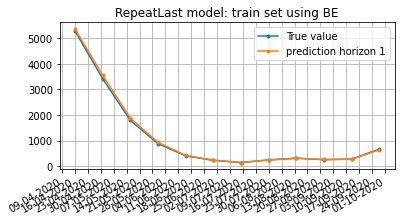

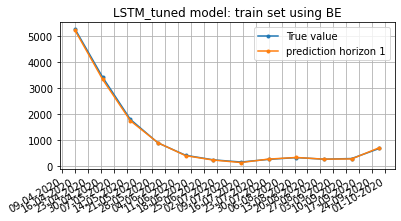

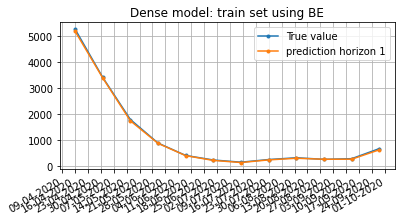

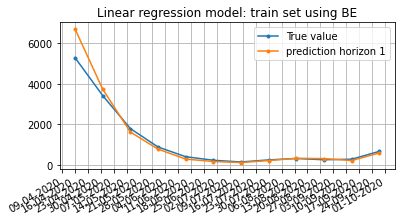

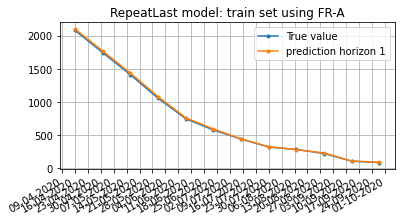

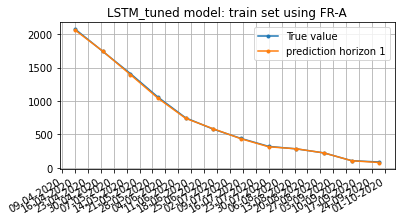

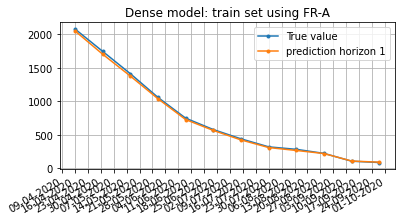

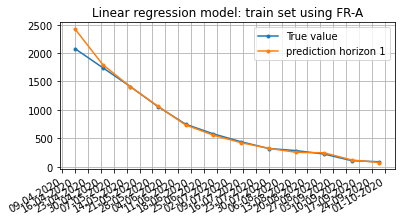

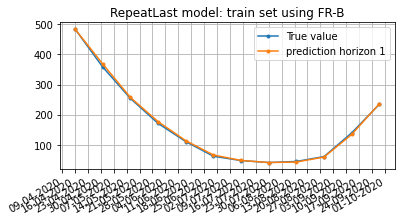

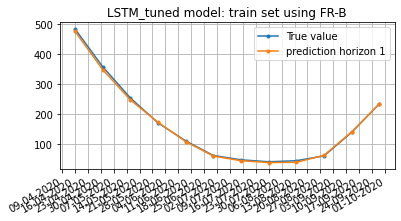

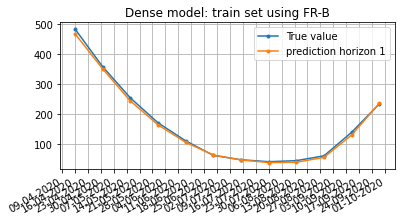

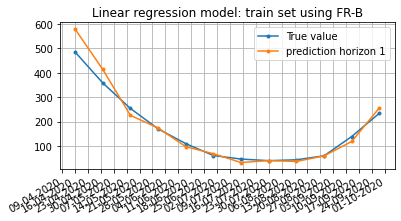

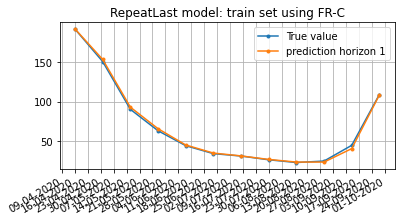

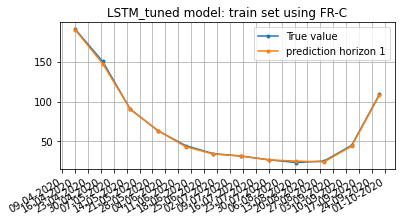

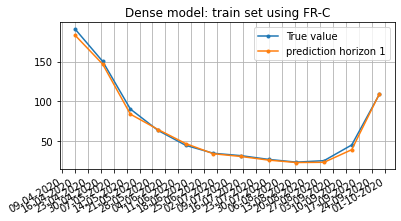

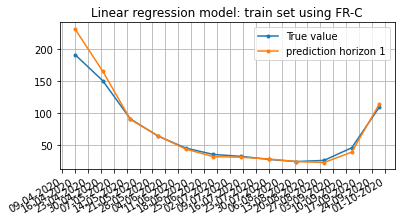

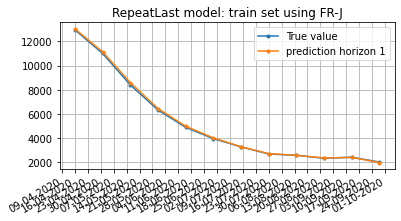

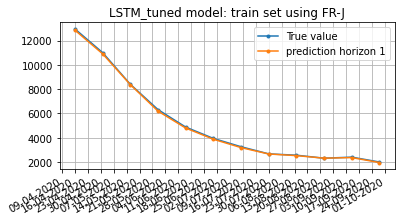

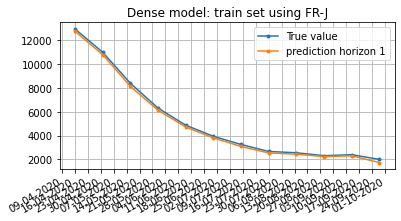

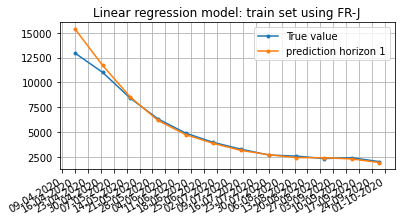

In [64]:
error_set(all_models, train_datapoints, plot=True, mode='train')

## Validation

BE
FR-A
FR-B
FR-C
FR-J


,MSE (t+1),MAE (t+1),MSE (t+2),MAE (t+2),MSE (t+3),MAE (t+3),MSE (t+4),MAE (t+4),MSE (t+5),MAE (t+5),...,MSE (t+11),MAE (t+11),MSE (t+12),MAE (t+12),MSE (t+13),MAE (t+13),MSE (t+14),MAE (t+14),MSE (t+15),MAE (t+15)
Model,,,,,,,,,,,,,,,,,,,,,
RepeatLast,9636.421827,57.434570,38629.024572,115.553870,86896.317437,174.138830,154182.811607,233.028555,240077.435062,292.200986,...,1.104414e+06,647.710262,1.296839e+06,706.156381,1.499548e+06,763.740341,1.711082e+06,820.168915,1.929934e+06,876.052624
Dense,24600.362378,97.066617,50074.282356,138.327353,69344.358071,157.070626,170702.707278,240.098837,173915.339898,241.918223,...,7.419943e+05,490.844162,9.691051e+05,567.004343,1.315011e+06,672.664836,1.233297e+06,641.674917,1.377862e+06,680.802412
LSTM_tuned,34980.450345,119.348276,64612.507859,156.001754,124657.668453,215.985880,191529.867212,264.999797,262533.720809,309.807166,...,9.623192e+05,624.467135,1.099748e+06,670.858254,1.260554e+06,723.161489,1.348191e+06,747.643577,1.460013e+06,776.141022
Linear regression,185327.266367,243.558632,274546.554880,298.878084,387134.689306,357.972567,525258.775591,419.839721,690916.021711,484.927272,...,2.343406e+06,922.479613,2.735630e+06,1000.574357,3.161440e+06,1079.896923,3.620321e+06,1160.359348,4.111583e+06,1240.604134


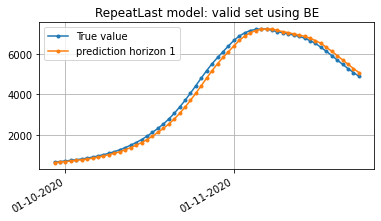

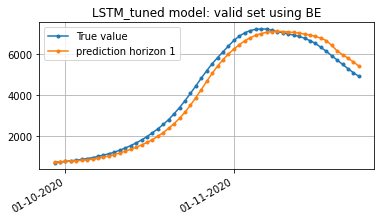

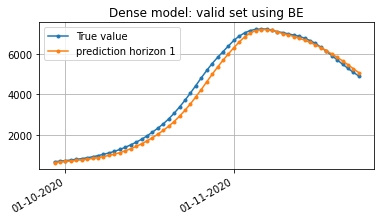

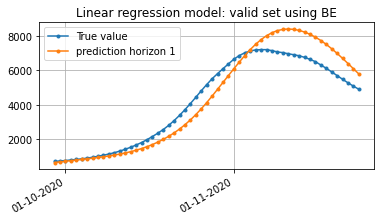

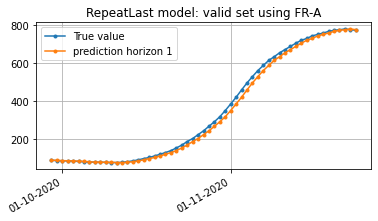

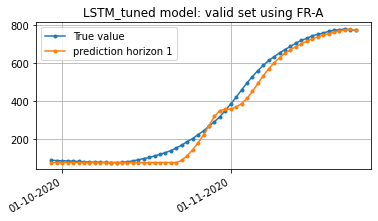

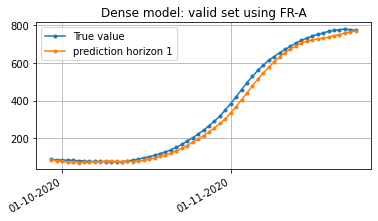

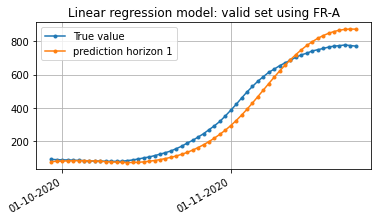

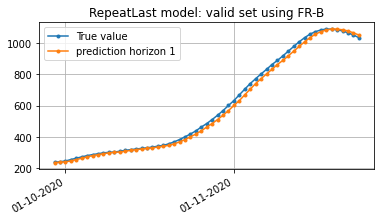

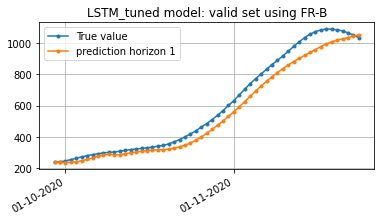

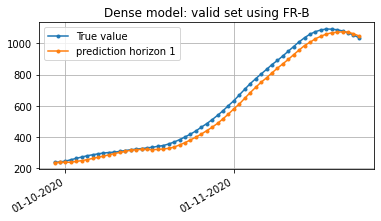

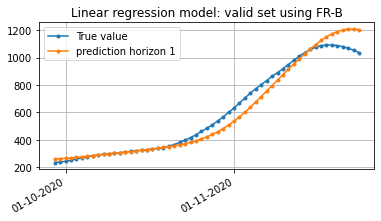

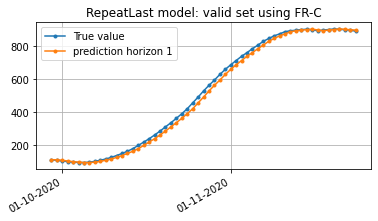

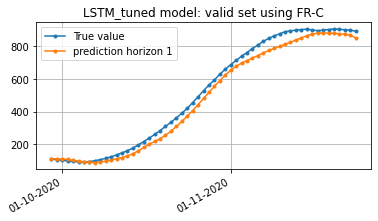

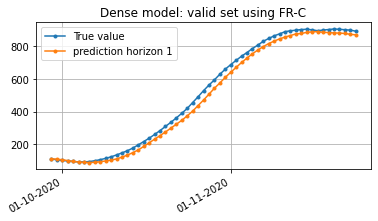

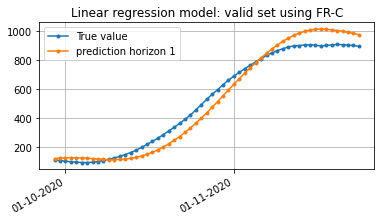

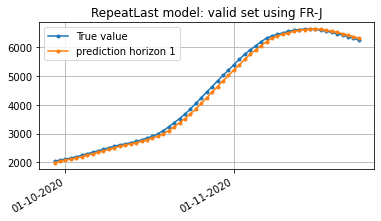

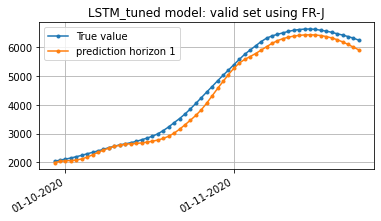

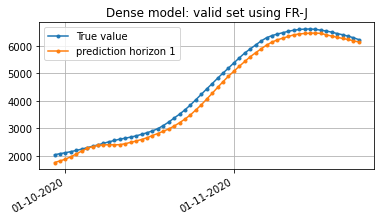

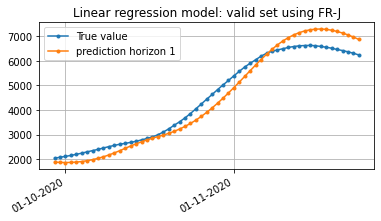

In [65]:
error_set(all_models, valid_datapoints, plot=True, mode='valid')

## Test

BE
FR-A
FR-B
FR-C
FR-J


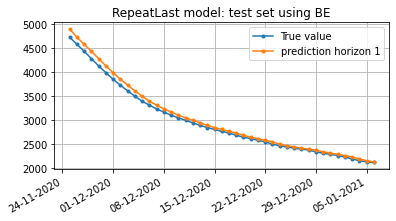

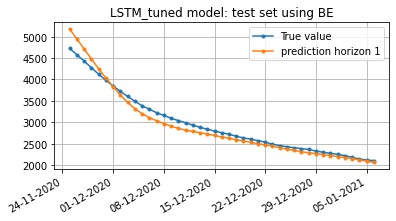

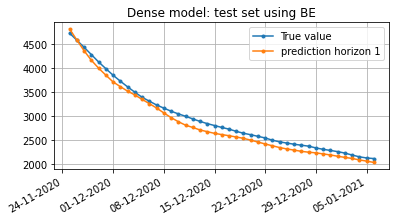

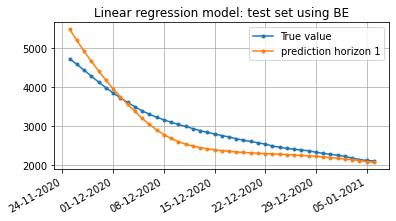

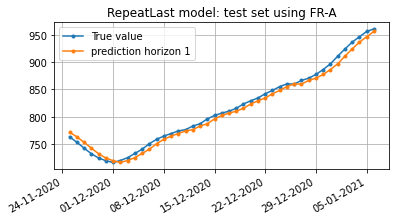

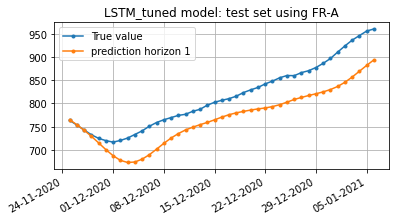

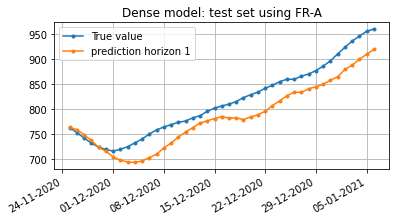

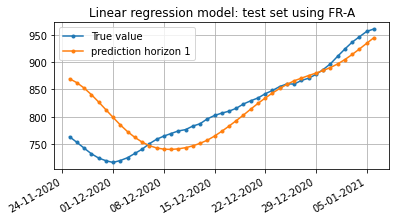

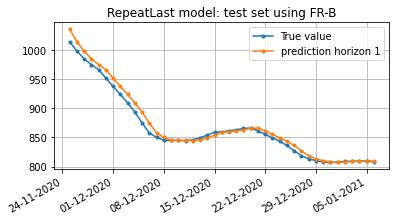

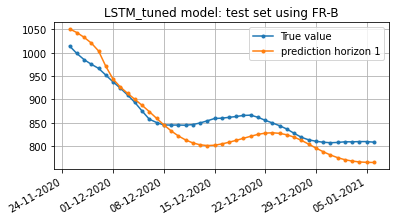

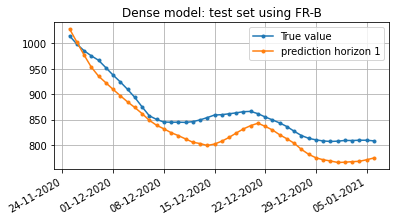

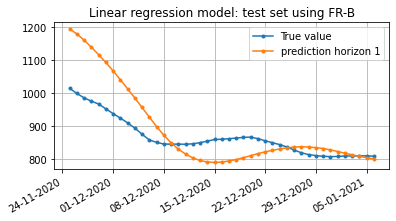

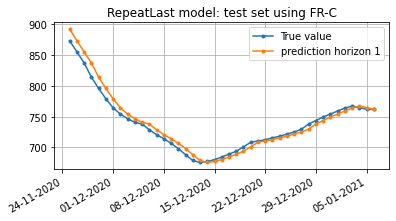

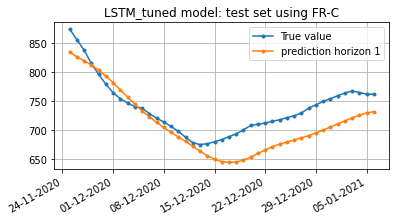

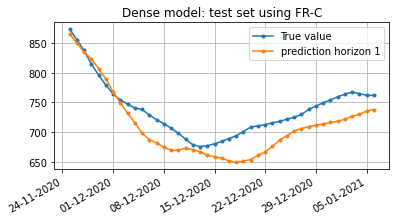

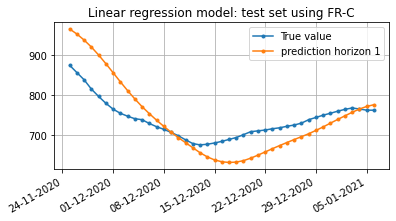

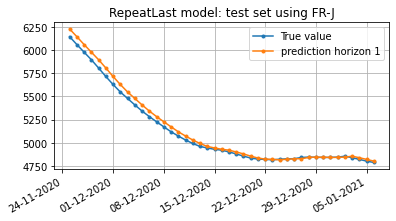

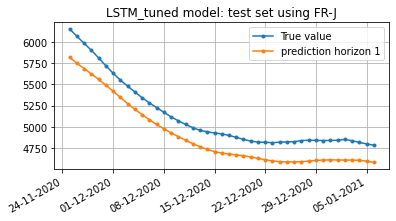

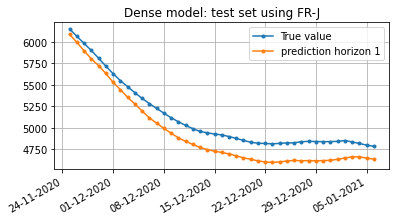

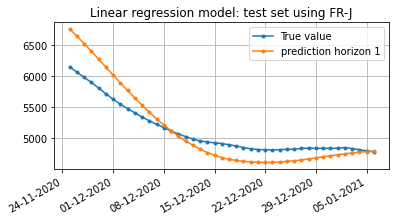

In [69]:
df = error_set(all_models, test_datapoints, plot=True, mode='test')

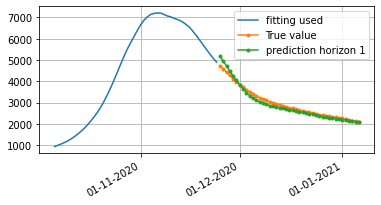

In [68]:
idx = test_idx
x = test_datapoints['BE'][0]
yp = best_model.predict(x)
plot_prediction_vs_actual(yp, idx, 'BE', show_fit=50)